<a href="https://colab.research.google.com/github/yuki0703-sudo/Research/blob/main/Tracking_Method_BGS_ColorTracking_YOLO_OpticalFlow_TemplateMatching_KalmanFilter_3DReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import cv2 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow
import scipy.ndimage as ndimage

In [9]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Color detection

In [10]:
import cv2
import numpy as np

#Dilation

In [11]:
def dilation(img,dilationSize, kernelSize):  # 膨張した画像にして返す
    kernel = np.ones((kernelSize, kernelSize), np.uint8)
    element = cv2.getStructuringElement(
        cv2.MORPH_RECT, (2 * dilationSize + 1, 2 * dilationSize + 1), (dilationSize, dilationSize))
    dilation_img = cv2.dilate(img, kernel, element)
    return dilation_img

In [12]:
# detect red color
def detect_red_color(img):
  #transfer HSV field
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  #range of red 1
  hsv_min = np.array([0,90,90])
  hsv_max = np.array([30,255,255])
  mask1 = cv2.inRange(hsv,hsv_min,hsv_max)

  #range of red 2
  hsv_min = np.array([150,90,90])
  hsv_max = np.array([30,255,255])
  mask2 = cv2.inRange(hsv,hsv_min,hsv_max)

  mask = mask1+mask2

  #masking process
  masked_img = cv2.bitwise_and(img,img,mask = mask)

  return mask, masked_img

#detect green color
def detect_green_color(img):
  #transfer HSV field
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  #1st range of green
  hsv_min = np.array([30, 64, 0])
  hsv_max = np.array([90,255,255])
  mask1 = cv2.inRange(hsv,hsv_min,hsv_max)

  #combine mask 
  mask = mask1

  masked_img = cv2.bitwise_and(img,img,mask = mask)

  return mask, masked_img

#detect blue color
def detect_blue_color(img):
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  hsv_min = np.array([90, 64, 0])
  hsv_max = np.array([150,255,255])

  mask = cv2.inRange(hsv,hsv_min,hsv_max)

  masked_img = cv2.bitwise_and(img,img,mask = mask)

  return mask, masked_img

#detect orange color
def detect_orange_color(img):
  #transfer HSV field
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
#9, 100, 100), cv::Scalar(29, 255, 255)
  #1st range of green
#  hsv_min = np.array([10, 130,130])
#  hsv_max = np.array([45,255,255])
  hsv_min = np.array([9,100,100])
  hsv_max = np.array([29,255,255])
  mask1 = cv2.inRange(hsv,hsv_min,hsv_max)

  #combine mask 
  mask = mask1

  #opening process
  kernel = np.ones((5,5),np.uint8)
  opening = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

  masked_img = cv2.bitwise_and(img,img,mask = mask)

  return opening,masked_img
  #return mask, masked_img


#Confirm mask imgae

In [14]:
from google.colab.patches import cv2_imshow

img = cv2.imread('/ontent/gdrcive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/010.jpg')#ObjectTracking/20221221/1/cam_1/020.jpg' )
mask, masked_img = detect_orange_color(img)

cv2_imshow(masked_img)

error: ignored

#Dilation

In [ ]:
def dilation(img,dilationSize, kernelSize):  # 膨張した画像にして返す
    kernel = np.ones((kernelSize, kernelSize), np.uint8)
    element = cv2.getStructuringElement(
        cv2.MORPH_RECT, (2 * dilationSize + 1, 2 * dilationSize + 1), (dilationSize, dilationSize))
    dilation_img = cv2.dilate(img, kernel, element)
    return dilation_img

In [ ]:
from google.colab.patches import cv2_imshow
#dilation_mask = dilation(img=mask,dilationSize=5, kernelSize=5)

#opening process
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

#closing process
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#morphology process
kernel = np.ones((5,5),np.uint8)
morphology = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)

cv2_imshow(mask)
cv2_imshow(opening)
cv2_imshow(closing)
#cv2_imshow(morphology)

#cv2_imshow(dilation_mask)
cv2_imshow(masked_img)

NameError: ignored

In [15]:
import cv2
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
import time
from numpy import dtype,uint8
import scipy.ndimage as ndimage
from scipy.optimize import curve_fit
from google.colab.patches import cv2_imshow

#static

325.0
688.0
equivalent radius:
area-based:14.8 pixel,arclength-based:16.2 pixel


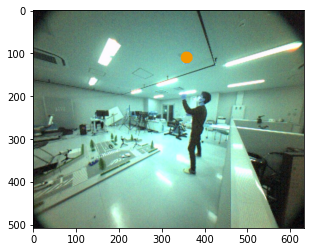

In [20]:
img = cv2.imread('/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/021.jpg')#ObjectTracking/20221221/1/cam_1/020.jpg' )#"/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/cam_0/020.jpg")
mask, masked_img = detect_orange_color(img)
# 輪郭を抽出する。
contours, hierarchy = cv2.findContours(np.array(mask,dtype=np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda x: cv2.contourArea(x) > 300, contours))

#plt.imshow(img)
#print(contours)
#面積、円形度、等価直径を求める。
Areas = []
Circularities = []
Eq_diameters = []
x_joint = []
y_joint = []
#print(contours)
for i in contours:
  area = cv2.contourArea(i)
  print(area)
  Areas.append(area)
if bool(Areas)==True:
  idx = np.argmax(Areas)
  #print(idx)
  area = Areas[idx]
  i = contours[idx]
  arc = cv2.arcLength(i, True)
  circularity = 4 * np.pi * area / (arc * arc)
  #print(circularity)
  #マーカー位置計算
  mu=cv2.moments(i)
  x=int(mu["m10"]/mu["m00"])
  y=int(mu["m01"]/mu["m00"])
  x_joint.append(x)
  y_joint.append(y)
  #面積(px*px)
  area = cv2.contourArea(i)
  arc = cv2.arcLength(i, True)
  r_1 = (area/np.pi)**(1/2)
  r_2 = arc/(2*np.pi)
  print('equivalent radius:\narea-based:{:.1f} pixel,arclength-based:{:.1f} pixel'.format(r_1,r_2))
  #print(area)
  cv2.circle(img,center=(x,y),radius=int(r_1),color=(243,152,0),thickness=-1)
  #cv2.circle(img,(x,y),30,(255,0,0),-1)
  #cv2.putText(img, 'x:{},y:{}'.format(x,y), (x-300,y-80), cv2.FONT_HERSHEY_PLAIN, 5, (255, 0, 0), 3, cv2.LINE_AA)

plt.imshow(img)


#Median Filter

Process TIme: 0.04 Hz


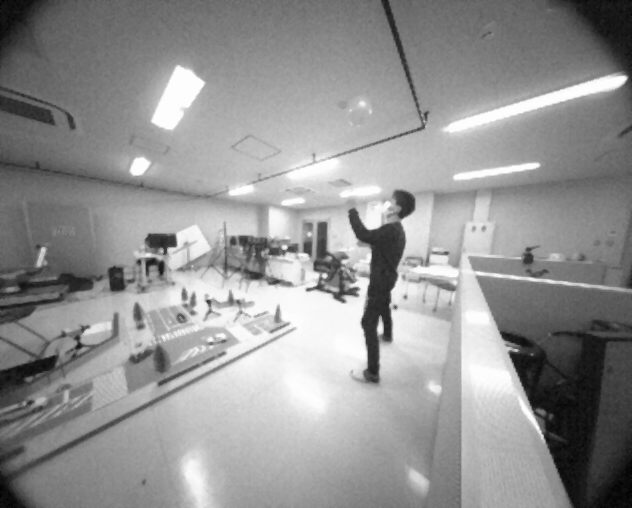

In [18]:
#-*- coding:utf-8 -*-
import cv2
import numpy as np
import time 


def median_filter(src, ksize):
    # 畳み込み演算をしない領域の幅
    # width of skip
    d = int((ksize-1)/2)
    h, w = src.shape[0], src.shape[1]

    # ndarray of destination
    # 出力画像用の配列（要素は入力画像と同じ）
    dst = src.copy()

    for y in range(d, h - d):
        for x in range(d, w - d):
            # 近傍にある画素値の中央値を出力画像の画素値に設定
            dst[y][x] = np.median(src[y-d:y+d+1, x-d:x+d+1])

    return dst


# load image (grayscale)
# 入力画像をグレースケールで読み込み
t1 = time.time()
gray = cv2.imread("/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/021.jpg", 0)

# Spatial filtering
# 方法1
dst = median_filter(gray, ksize=3)
t2 = time.time()
freq = 1/(t2-t1)
print("Process TIme: {:.2f} Hz".format(freq))
cv2_imshow(dst)

#Image Sharpening

Process TIme:56.0 Hz


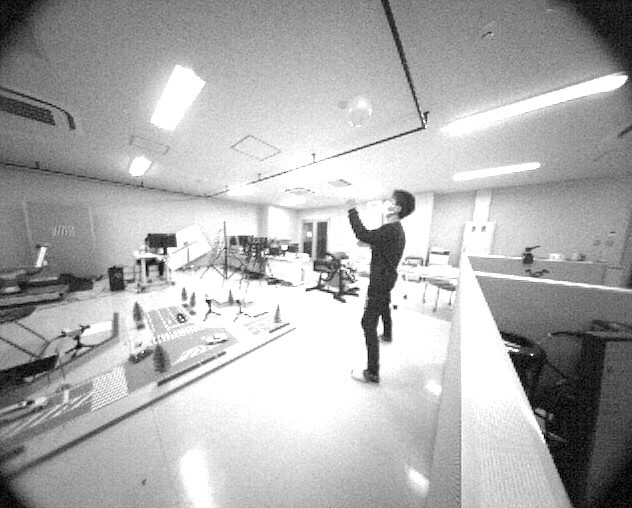

In [22]:
import cv2
import numpy as np


def make_sharp_kernel(k: int):
  return np.array([
    [-k / 9, -k / 9, -k / 9],
    [-k / 9, 1 + 8 * k / 9, k / 9],
    [-k / 9, -k / 9, -k / 9]
  ], np.float32)

t1 = time.time()
img = cv2.imread("/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/021.jpg",0)
kernel = make_sharp_kernel(1)
img = cv2.filter2D(img, -1, kernel).astype("uint8")
t2 = time.time()
freq = 1/(t2-t1)

print("Process TIme:{:.1f} Hz".format(freq))
cv2_imshow(img)

# for video

In [23]:
import glob
import csv
import os

#ffmpegを使って動画を画像に変換する
s=0 #周波数計算用，sum
fps=30 #取得画像のfps
dat=[] #[x_average,y_average,x_velocity,y_velocity]
#マーカートラッキング評価用
accuracy=0
error_list=[]

src_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/'#ObjectTracking/20221221/1/cam_1' ##Chnage here
#//////////////////////

src_files=glob.glob("{}/*.jpg".format(src_img_dir))
src_files.sort()
print(src_files)
#画像の保存ディレクトリ
# Change here /////////////
#dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/1/cam_1/color_tracking'
#///////////////////////


'''
if not os.path.exists(dst_img_dir):
  os.makedirs(dst_img_dir)

src_img_dir="/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/cam_1"

#src_img_dirがなかったら、srcフォルダを作成する
import os
if not os.path.exists(src_img_dir):
  os.makedirs(src_img_dir)
'''

#抽出された画像をsrcディレクトリに保存#fpsを指定,今回は536fps
#!ffmpeg -i "/content/gdrive/My Drive/YAMAKAWA_LAB/motion_tracking/sample.mp4" -vf fps=530 "$src_img_dir/%04d.jpg" #-vf video to frame


#フォルダに存在するファイルを取得する、0001.jpg~0005.jpg→{}/*.jpg
src_files=glob.glob("{}/*.jpg".format(src_img_dir))
src_files.sort()

#print(len(src_files), "image files")

#画像の保存ディレクトリ
dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/color_tracking'#ObjectTracking/20221221/1/cam_1/Processed'
#out_img='/content/gdrive/My Drive/YAMAKAWA_LAB/motion_tracking/wavehand/output'

#出力ファイル名
#filename='/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/1/cam_1/xydata.csv'

#data=np.arange(9).reshape(3,3)
#np.savetxt("/content/gdrive/My Drive/YAMAKAWA_LAB/motion_tracking/data.txt",data,fmt='%d')
#data=data.flatten()

#ファイルを作成
#with open(filename,"w") as f:
#  writer = csv.writer(f)
#  writer.writerow(["x","y"])

if not os.path.exists(dst_img_dir):
  os.makedirs(dst_img_dir)

trajectory_x=[]
trajectory_y=[]
radius = []
radius2 = []

for j,file in enumerate(src_files): #index,components=enumerate(file)
  print(file)
  #t1=time.time()#周波数計算用，開始時間

  # 画像を読み込む。
  img=cv2.imread(file)
  
  mask, masked_img = detect_orange_color(img)

  # グレースケールに変換する。
  #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # 2値化する
  #ret, bin_img = cv2.threshold(gray, 33, 255, cv2.THRESH_BINARY)

  # 輪郭を抽出する。
  contours, hierarchy = cv2.findContours(np.array(mask,dtype=np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # 小さい輪郭は誤検出として削除する
  contours = list(filter(lambda x: cv2.contourArea(x) >=300, contours))
  #contours = list(filter(lambda x: cv2.contourArea(x) <= 100000, contours))
 # contours = list(filter(lambda x: cv2.contourArea(x) >=1000, contours))
 # contours = list(filter(lambda x: cv2.contourArea(x) <= 100000, contours))

  # 輪郭を描画する。
  #cv2.drawContours(img, contours, -1, color=(0, 0, 255), thickness=2)

  #面積、円形度、等価直径を求める。
  Areas = []
  Circularities = []
  #Eq_diameters = []

  x_c=0 #重心位置_x
  y_c=0 #重心位置_y
  e_c=0 #輪郭検出用変数

  

  #輪郭検出，マーカー位置取得，ループ構造

  #精度評価用
  count=0
  if bool(contours) == True:
    for i in contours:
      Areas.append(cv2.contourArea(i))
    print(Areas)
    idx = np.argmax(Areas)
    print(idx)
    c = contours[idx]
    area = Areas[idx]
    #円形度
    #arcLength(curve,ret) #輪郭の長さを返す，curve:輪郭情報，ret:平曲線かどうか
    arc = cv2.arcLength(c, True)
    circularity = 4 * np.pi * area / (arc * arc)
    #重心位置を求める
    #if circularity > 0.3 and circularity<1.1: 

      # 輪郭を描画する。
      #cv2.drawContours(img, contours, 1, color=(0, 0, 255), thickness=2)

      #マーカー位置計算
      #mu=cv2.moments(c)
      #x=int(mu["m10"]/mu["m00"])
      #y=int(mu["m01"]/mu["m00"])
      #trajectory_x.append(x)
      #trajectory_y.append(y)
      #r = (area/np.pi)**(1/2)
      #r2 = (arc/2/np.pi)
      #radius.append(r)
      #radius2.append(r2)
      #cv2.circle(img,center=(x,y),radius=int(r2),color=(0,255,0),thickness=10)
      #cv2.putText(img, 'x:{},y:{},r:{}'.format(x,y,int(r2)), (x-300,y+100), cv2.FONT_HERSHEY_PLAIN, 5, (255, 0, 0), 3, cv2.LINE_AA)
      #dst_file = "{dir}/{index:04d}.jpg".format(dir=dst_img_dir,index=j+1)
      #cv2.imwrite(dst_file,img)
    mu=cv2.moments(c)
    x=int(mu["m10"]/mu["m00"])
    y=int(mu["m01"]/mu["m00"])
    trajectory_x.append(x)
    trajectory_y.append(y)
    r = (area/np.pi)**(1/2)*2
    r2 = (arc/2/np.pi)
    cv2.circle(img,center=(x,y),radius=int(r),color=(0,255,0),thickness=5)
    radius.append(r)
    radius2.append(r2)
    #ファイルに重心座標を書き込む  
    #with open(filename,"a",newline='') as f:
    #    writer = csv.writer(f)
    #    writer.writerow([x,y])
  else:
    trajectory_x.append(None)
    trajectory_y.append(None)
    radius.append(None)
    radius2.append(None)
    #with open(filename,"a",newline='') as f:
    #    writer = csv.writer(f)
    #    writer.writerow([0,0])  
  #else:
  dst_file = "{dir}/{index:03d}.jpg".format(dir=dst_img_dir,index=j+1)
  cv2.imwrite(dst_file,img)

    

['/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/001.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/002.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/003.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/004.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/005.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/006.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/007.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/008.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/009.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/010.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/011.jpg', '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/

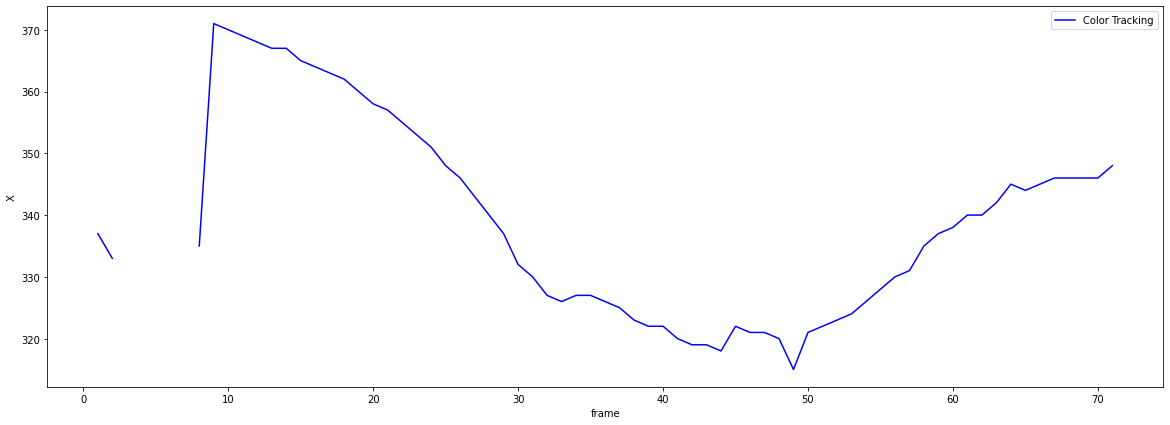

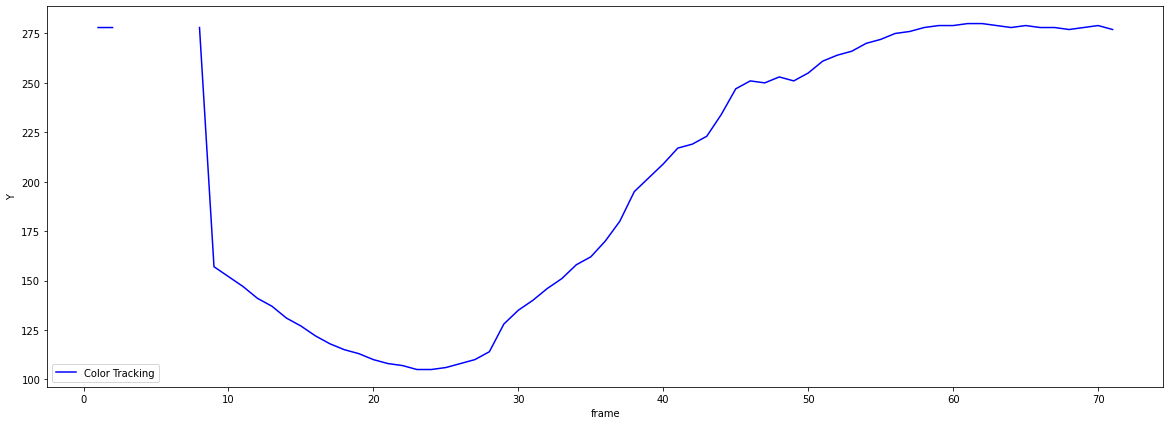

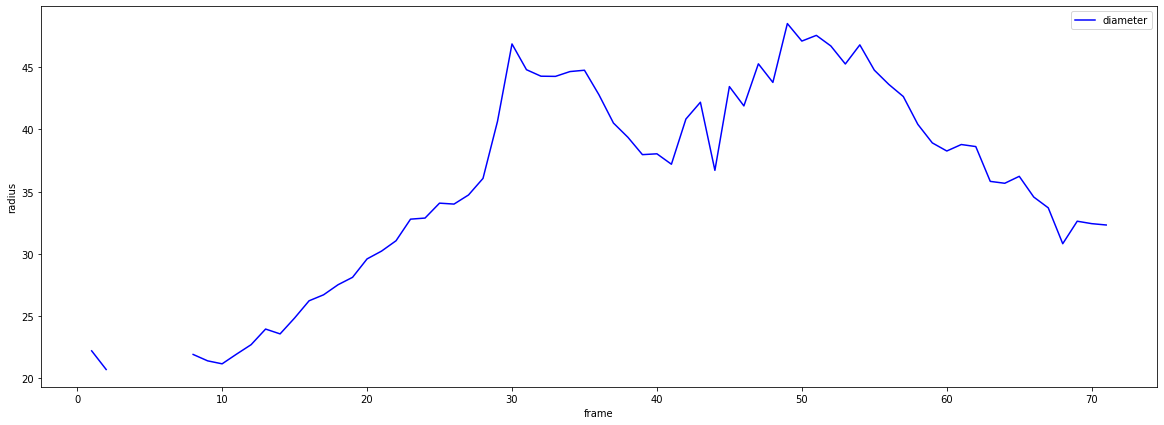

In [25]:
plt.figure(figsize=(20,7))
#plt.plot(x_templ,color="r")
plt.plot(trajectory_x,color="b",label='Color Tracking')
plt.xlabel('frame')
plt.ylabel('X')
plt.legend()
plt.show()
plt.figure(figsize=(20,7))
#plt.plot(y_templ,color="r")
plt.plot(trajectory_y,color="b",label='Color Tracking')
plt.xlabel('frame')
plt.ylabel('Y')
plt.legend()
plt.figure(figsize=(20,7))
#plt.plot(y_templ,color="r")
plt.plot(radius,color="b",label='diameter')
plt.xlabel('frame')
plt.ylabel('radius')
plt.legend()
plt.show()

#Offline Detection From YOLOv7

In [27]:
import pandas as pd
file = pd.read_csv(filepath_or_buffer = '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/gray/gray.csv')
value =file.values
print(value[1])

[  1.         365.         201.         384.         230.
   0.89941406   1.        ]


In [28]:
def classify_data(value):
  """classify data into ball, hand, elbow, body
  """

  #initialization
  limit = value.shape[0]-1

  #nd.array -> list
  value = value.tolist()

  # class : {0:"Ball",1:"Hand",2:"Elbow",3:"Body"}
  frame_0 = []
  frame_1 = []
  frame_2 = []
  frame_3 = []
  Ball = []
  Hand = []
  Elbow = []
  Body = []

  time_step = 1
  i = 0

  while i < limit: #total detection over a sequences

    #For confirming if object is detected or not in the time_step
    count_0 = 0
    count_1 = 0
    count_2 = 0
    count_3 = 0

    #check the progress state
    print((time_step,i))

    while value[i][0] == time_step and i <  limit:
      x = (value[i][1]+value[i][3])/2
      y = (value[i][2]+value[i][4])/2
      w = value[i][3]-value[i][1]
      h = value[i][4]-value[i][2]

      if int(value[i][-1]) == 0: #Ball 
        frame_0.append(time_step)
        temp = [x,y,w,h]
        Ball.append(temp)
        count_0 += 1

      elif int(value[i][-1]) == 1: #Hand
        frame_1.append(time_step)
        temp = [x,y,w,h]
        Hand.append(temp)
        count_1 += 1

      elif int(value[i][-1]) == 2: #Elbow
        frame_2.append(time_step)
        temp = [x,y,w,h]
        Elbow.append(temp)
        count_2 += 1

      elif int(value[i][-1]) == 3: #Body
        frame_3.append(time_step)
        temp = [x,y,w,h]
        Body.append(temp)
        count_3 += 1
    
      #next detection
      i += 1

    #If not detected
    if count_0 == 0:
      frame_0.append(time_step)
      temp = [None,None,None,None]
      Ball.append(temp)
    
    if count_1 == 0:
      frame_1.append(time_step)
      temp = [None,None,None,None]
      Hand.append(temp)
    
    if count_2 == 0:
      frame_2.append(time_step)
      temp = [None,None,None,None]
      Elbow.append(temp)
    
    if count_3 == 0:
      frame_3.append(time_step)
      temp = [None,None,None,None]
      Body.append(temp)

    #next time-step
    time_step += 1
  
  frame_0 = np.asarray(frame_0)
  frame_1 = np.asarray(frame_1)   
  frame_2 = np.asarray(frame_2)
  frame_3 = np.asarray(frame_3)
  Ball = np.asarray(Ball)
  Hand = np.asarray(Hand)
  Elbow = np.asarray(Elbow)
  Body = np.asarray(Body)

  return frame_0,frame_1,frame_2,frame_3,Ball,Hand,Elbow,Body

In [29]:
frame_0,frame_1,frame_2,frame_3,Ball,Hand,Elbow,Body = classify_data(value)

(1, 0)
(2, 3)
(3, 7)
(4, 10)
(5, 13)
(6, 18)
(7, 20)
(8, 22)
(9, 24)
(10, 27)
(11, 31)
(12, 34)
(13, 38)
(14, 42)
(15, 45)
(16, 49)
(17, 53)
(18, 57)
(19, 62)
(20, 66)
(21, 70)
(22, 73)
(23, 77)
(24, 81)
(25, 85)
(26, 89)
(27, 92)
(28, 95)
(29, 99)
(30, 102)
(31, 105)
(32, 108)
(33, 111)
(34, 114)
(35, 116)
(36, 119)
(37, 122)
(38, 125)
(39, 129)
(40, 131)
(41, 135)
(42, 138)
(43, 141)
(44, 144)
(45, 147)
(46, 150)
(47, 153)
(48, 157)
(49, 161)
(50, 163)
(51, 166)
(52, 167)
(53, 169)
(54, 170)
(55, 171)
(56, 172)
(57, 175)
(58, 178)
(59, 182)
(60, 185)
(61, 188)
(62, 191)
(63, 194)
(64, 197)
(65, 200)
(66, 203)
(67, 206)
(68, 208)
(69, 210)
(70, 211)
(71, 213)
(72, 214)


#Plot Data

In [32]:
def find_fault(data,category):
  """calculate the frame in which object can't be detected
  """
  count = 0
  for i in range(data.shape[0]):
    if data[i][0] == None:
      count += 1
  print("{}::Fault : {count}/{total}".format(category,count = count,total = frame_0[-1]))

def find_duplication(data,category):
  """calculate the frame in which more than 1 objects are detected 
  """
  count = 0
  for i in range(1,data.shape[0]):
    duplicate = 0
    if data[i] == data[i-1] and duplicate == 0:
      count += 1
      duplicate += 1
  print("{} :: Duplicate : {count}/{total}".format(category,count=count,total=frame_0[-1]))

find_fault(Ball,"Ball")
find_fault(Hand,"Hand")
find_fault(Elbow,"Elbow")
find_fault(Body,"Body")

find_duplication(frame_0,"Ball")
find_duplication(frame_1,"Hand")
find_duplication(frame_2,"Elbow")
find_duplication(frame_3,"Body")

Ball::Fault : 18/72
Hand::Fault : 18/72
Elbow::Fault : 48/72
Body::Fault : 0/72
Ball :: Duplicate : 2/72
Hand :: Duplicate : 9/72
Elbow :: Duplicate : 0/72
Body :: Duplicate : 0/72


## Plot the detection data

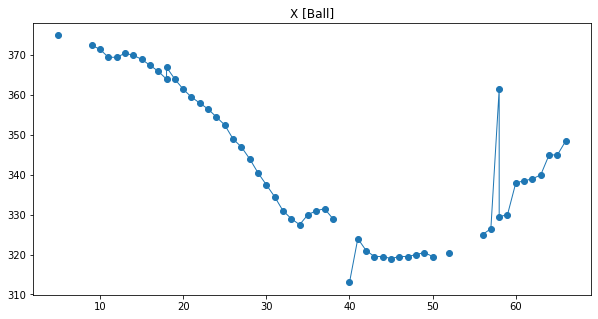

Text(0.5, 1.0, 'Y [Body]')

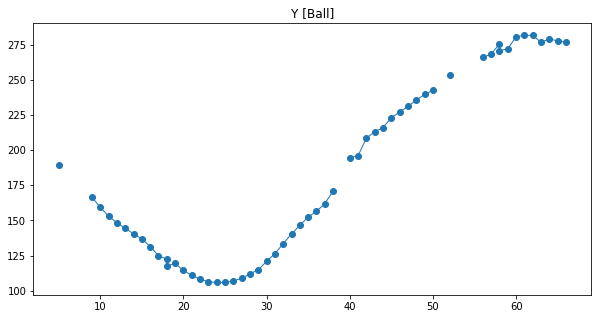

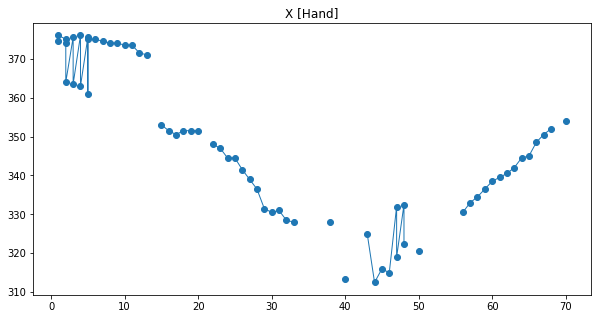

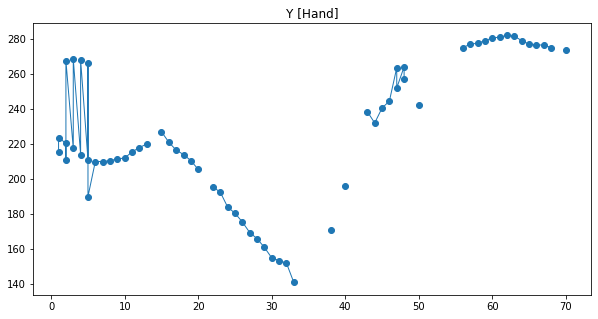

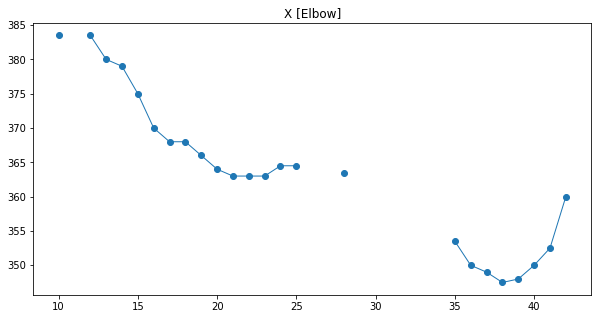

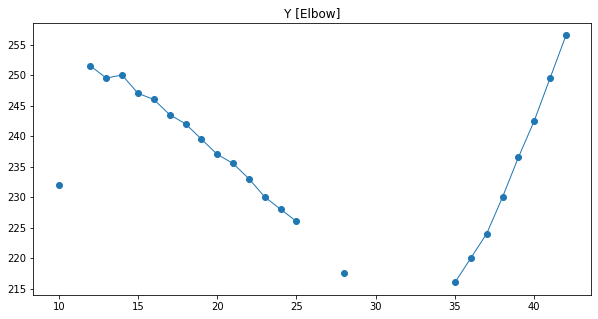

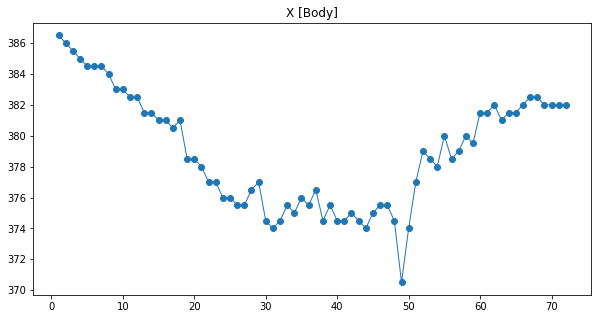

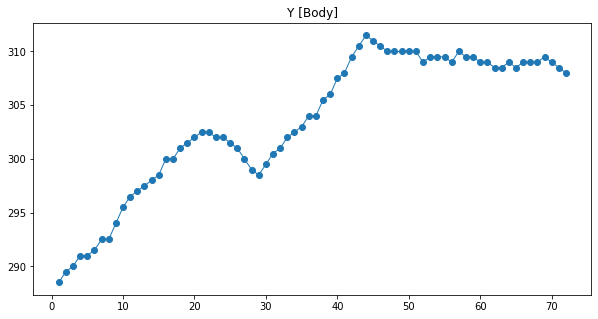

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(frame_0,Ball[:,0],linewidth= 1,marker='o')
plt.title('X [Ball]')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(frame_0,Ball[:,1],linewidth=1,marker='o')
plt.title('Y [Ball]')
plt.subplots(figsize=(10,5))
plt.plot(frame_1,Hand[:,0],linewidth= 1,marker='o')
plt.title('X [Hand]')
plt.figure(figsize=(10,5))
plt.plot(frame_1,Hand[:,1],linewidth= 1,marker='o')
plt.title('Y [Hand]')
plt.figure(figsize=(10,5))
plt.plot(frame_2,Elbow[:,0],linewidth= 1,marker='o')
plt.title('X [Elbow]')
plt.figure(figsize=(10,5))
plt.plot(frame_2,Elbow[:,1],linewidth= 1,marker='o')
plt.title('Y [Elbow]')
plt.figure(figsize=(10,5))
plt.plot(frame_3,Body[:,0],linewidth= 1,marker='o')
plt.title('X [Body]')
plt.figure(figsize=(10,5))
plt.plot(frame_3,Body[:,1],linewidth= 1,marker='o')
plt.title('Y [Body]')

## Compare detection data with color ball tracking

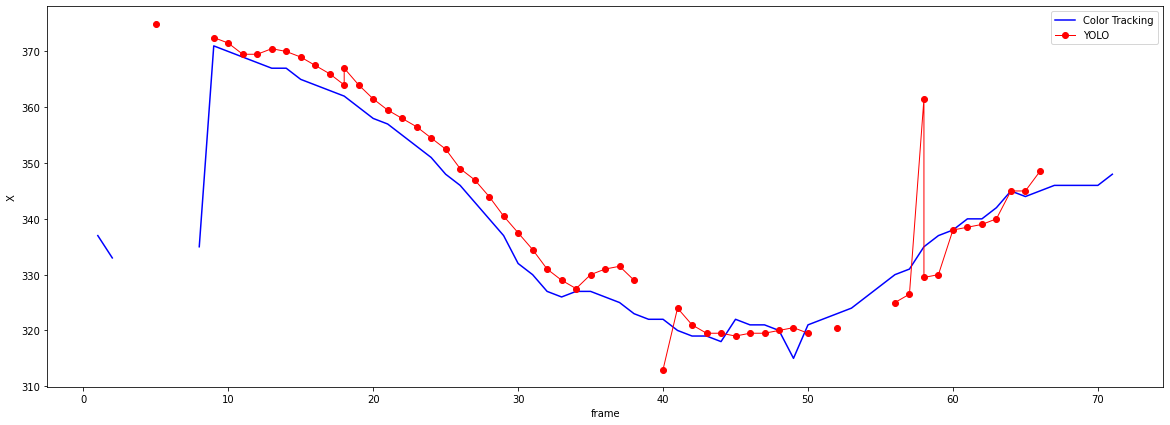

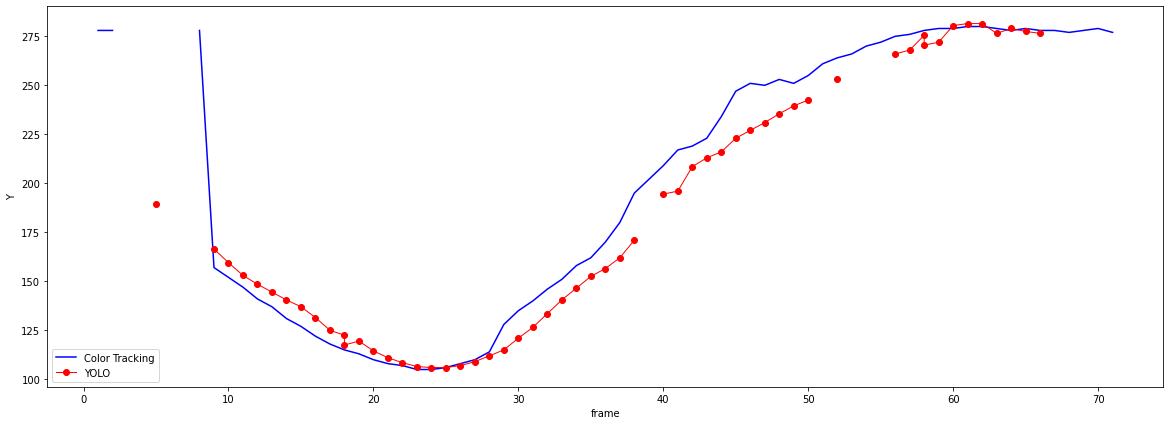

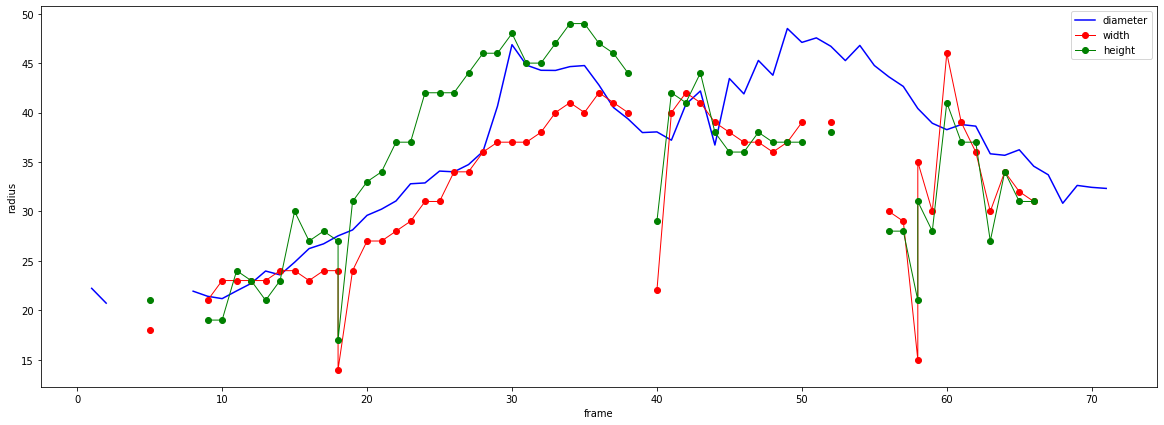

In [34]:
plt.figure(figsize=(20,7))
#plt.plot(x_templ,color="r")
plt.plot(trajectory_x,color="b",label='Color Tracking')
plt.plot(frame_0,Ball[:,0],linewidth= 1,marker='o',color='r',label='YOLO')
plt.xlabel('frame')
plt.ylabel('X')
plt.legend()
plt.show()
plt.figure(figsize=(20,7))
#plt.plot(y_templ,color="r")
plt.plot(trajectory_y,color="b",label='Color Tracking')
plt.plot(frame_0,Ball[:,1],linewidth= 1,marker='o',label='YOLO',color='r')
plt.xlabel('frame')
plt.ylabel('Y')
plt.legend()
plt.figure(figsize=(20,7))
#plt.plot(y_templ,color="r")
plt.plot(radius,color="b",label='diameter')
plt.plot(frame_0,Ball[:,2],linewidth= 1,marker='o',color='r',label='width')
plt.plot(frame_0,Ball[:,3],linewidth= 1,marker='o',color='g',label='height')
plt.xlabel('frame')
plt.ylabel('radius')
plt.legend()
plt.show()

#ColorTracking+BGS

#Background Subtraction

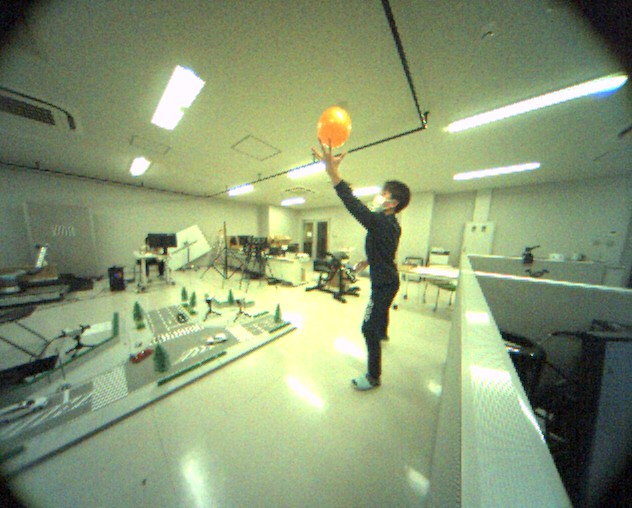

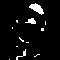

73.5
[26.5, 73.5]


In [35]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from numpy import uint8

th = 50
h = 30
w = 30
#read image
i=30
#img_src1 = cv2.imread("/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/video/xiQ_20220603_12-2/0100.jpg")
#img_src2 = cv2.imread("/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/video/xiQ_20220603_12-2/0300.jpg")
src_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/' ##Chnage here
img_src1 = cv2.imread("{dir}/{index:03d}.jpg".format(dir= src_img_dir,index=(i+1)))
img_src2 = cv2.imread("{dir}/{index:03d}.jpg".format(dir= src_img_dir,index=(i)))

x = int(trajectory_x[i-1])
y = int(trajectory_y[i-1])
img1 = img_src1[y-h:+y+h,x-w:x+w]
img2 = img_src2[y-h:+y+h,x-w:x+w]
gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
# 差分の絶対値を計算
mask = cv2.absdiff(gray1, gray2)
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
# 差分画像を二値化してマスク画像を算出
#mask[mask < th] = 0
#mask[mask >= th] = 255

ret_src, bin_mask = cv2.threshold(opening, th, 255, cv2.THRESH_BINARY)
cv2_imshow(img_src1)
cv2_imshow(bin_mask)

# 輪郭を抽出する。
contours_src, hierarchy_src = cv2.findContours(np.array(bin_mask,dtype=uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda x: cv2.contourArea(x) >20, contours_src))

#print(contours)
    #calculate area:
area = []
count=0
    #source image area
if bool(contours) == True:
    for c in contours:
      area.append(cv2.contourArea(c))

idx = np.argmax(area)
print(area[idx])

print(area)

#Function : IoU, ROI setting by YOLO

In [62]:
def calculate_iou(bboxA,bboxB):
  """ calculate IoU(Intersection over Union)
  Input:
  bboxA, bboxB : ROI data [x_center,y_center,width,height]
  Return:
  Iou (Intersection over Union)
  """
  #bboxA edge point
  x_al = bboxA[0]-bboxA[2]/2
  y_al = bboxA[1]-bboxA[3]/2
  x_ar = bboxA[0]+bboxA[2]/2
  y_ar = bboxA[1]+bboxA[3]/2
  #bboxB edge point
  x_bl = bboxB[0]-bboxB[2]/2
  y_bl = bboxB[1]-bboxB[3]/2
  x_br = bboxB[0]+bboxB[2]/2
  y_br = bboxB[1]+bboxB[3]/2
  #intersection edge point
  x_il = max(x_al,x_bl)
  y_il = max(y_al,y_bl)
  x_ir = min(x_ar,x_br)
  y_ir = min(y_ar,y_br)

  #calculate intersection area
  S_i = max(0,x_ir-x_il+1)*max(0,y_ir-y_il+1)

  #calculate total area
  S_total = bboxA[2]*bboxA[3] + bboxB[2]*bboxB[3] - S_i

  IoU = S_i / S_total

  return IoU

def set_ROI(data,frame,idx):
  """setting ROI from YOLO
  Input:
  /data:trajectory of object {0:ball,1:hand,2:elbow,3:boody}
  /frame:frame list, here fram_0, frame_1, frame_2, frame_3
  /idx: frame index of detected object
  Return:
  if Detected:
    /x,y: center of ROI
    /w,h: wiidth, height of ROI
  else:
    /None,None,None,NOne

  """
  index = np.where(frame == idx)[0] #get index
  num_candidate = index.shape[0] # number of candidate
  candidate = data[index] # candidate ROI for updating, shape:(n,4) n:num of candidates

  #main loop of deciding ROI
  #if candidate is one
  if num_candidate == 1: 

    #If can't detect object:
    if candidate[0][0] == None:
        return None,None,None,None
    #Detected    
    else:
        return candidate[0][0],candidate[0][1],candidate[0][2],candidate[0][3] #x_center,y_center,width,height
  
  #if num of candidates are many or how to determine the reliability of the ROI -> future work : eg) BGS limit the searching area or considering the position constraints
  #else:


def get_ROI(data,frame,idx,old_frame,threshold):
  """Getting ROI from YOLO
  Input:
  /data:trajectory of object {0:ball,1:hand,2:elbow,3:boody}
  /frame:frame list, here fram_0, frame_1, frame_2, frame_3
  /idx: frame index of detected object
  /old_frame : previous ROI
  /threshold : IoU threshold
  Return:
  if IoU > threshold:
    /x,y: center of ROI
    /w,h: wiidth, height of ROI
  else:
    /old_frame ROI
  """


  index = np.where(frame == idx)[0] #get index
  num_candidate = index.shape[0] # number of candidate
  candidate = data[index] # candidate ROI for updating, shape:(n,4) n:num of candidates

  #main loop of deciding ROI
  #if candidate is one
  if num_candidate == 1: 

    #If can't detect object:
    if candidate[0][0] == None:
        return old_frame[0],old_frame[1],old_frame[2],old_frame[3]

    #Detected    
    else:
      IoU = calculate_iou(old_frame, candidate[0]) 
      if IoU > threshold : #adapt new ROI
        return candidate[0][0],candidate[0][1],candidate[0][2],candidate[0][3] #x_center,y_center,width,height
      else: #deny new ROI
        return old_frame[0],old_frame[1],old_frame[2],old_frame[3]

  #if candidates are more than 1
  elif num_candidate >= 2: 
    #determin most possible ROI
    temp_iou = []
    for i in range(num_candidate):
      iou = calculate_iou(old_frame, candidate[i])
      temp_iou.append(iou)
    index = np.argmax(temp_iou)
    IoU = temp_iou[index]

    #adapt new ROI
    if IoU > threshold : 
      return candidate[0][0],candidate[0][1],candidate[0][2],candidate[0][3] #x_center,y_center,width,height
    #deny new ROI
    else:
      return old_frame[0],old_frame[1],old_frame[2],old_frame[3]

#Checking Feature Points

(508, 632)


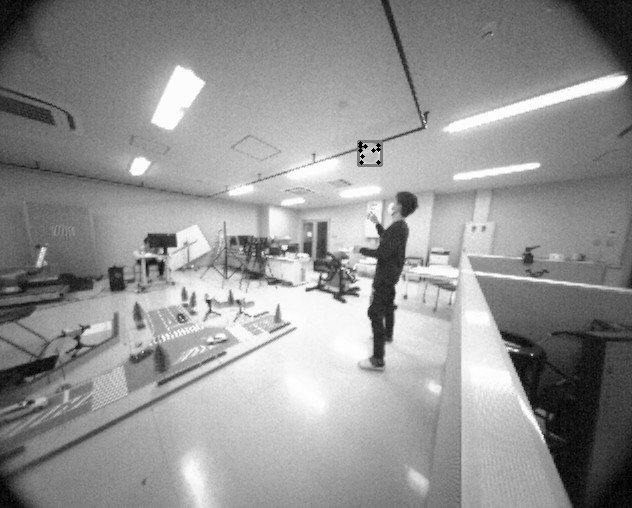

In [48]:
feature_params = dict( maxCorners =10,
                       qualityLevel = 0.1,
                       minDistance = 3,
                       blockSize = 3 )

img = cv2.imread('/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/011.jpg',0)
print(img.shape)

x,y,w,h = set_ROI(Ball,frame_0,11)
#x,y,w,h = set_ROI(Hand,frame_1,10)
#x,y,w,h = set_ROI(Elbow,frame_2,10)
#x,y,w,h = set_ROI(Body,frame_3,10)
if x != None:
  xl = int(x-w/2)
  xr = int(x+w/2)
  yl = int(y-h/2)
  yr = int(y+h/2)
  temp = img[yl:yr,xl:xr]
else:
  print(None)

#convert to a gray image
old_gray = temp
#cv2_imshow(old_gray)
cv2.rectangle(img,(xl,yl),(xr,yr),color = (125),thickness=2)
#detect feature points by Shi-Tomashi method
#return : feature points :shape(num_points,2)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

#check feature points
for p in p0:
  a,b = p.ravel() #ravel():change from multi-dimensional array to 1-dimensional array
  cv2.circle(temp,(int(a),int(b)),2,(0,255,255),-1)
cv2_imshow(temp)
cv2_imshow(img)

#YOLO+OpticalFlow Tracking

In [49]:
from posixpath import ismount
from scipy.optimize._lsq.lsq_linear import in_bounds
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import statistics

#function
def abs_max(data):
  """find the value whose absolute value is the biggest
  input : data : list
  return : absolute max data
  """
  max = abs(data[0])
  for i in range(1,len(data)):
    if abs(data[i]) > max:
      max = data[i]
  return max

#///// Setting ////////
threshold = 0.1 #IoU threshold

src_files=glob.glob("{}/*.jpg".format(src_img_dir))
src_files.sort()
max = []
x_templ = []
y_templ = []

t = 0
t = 0
count = 0
error = []
x = None
y = None
num_yolo = 0 # number of detection
opticalflow_x = []
opticalflow_y = []

# Optical Flow
#Feature Extraction Setting: Shi-Tomashi corner detection
# params for ShiTomasi corner detection
feature_params = dict( maxCorners =30,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3 )

#Setting for LK method
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (3,3),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))
#////////////////////////////////

#Source://///////////////////////
src_img_dir= '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename'
#Save img  directory
dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/optical_flow'#ObjectTracking/20221221/1/cam_1/ColorTracking-TemplateMatching'
if not os.path.exists(dst_img_dir):
  os.makedirs(dst_img_dir)
# ///////////////////////////////////


for i,src in enumerate(src_files):
  print(i)
  dst_file = "{dir}/{index:03d}.jpg".format(dir=dst_img_dir,index=i)
  count += 1
  t1 = time.time()
  #read image as gray scale
  img = cv2.imread(src,0)

  #get object ROI from YOLO
  if num_yolo == 0:
    if (i-1)%5 == 0:
      x,y,w,h = set_ROI(Ball,frame_0,i)
      if x != None:
        print("first YOLO")
        num_yolo += 1
        w += 5
        h += 5
        temp = img[int(y-h/2):int(y+h/2),int(x-w/2):int(x+w/2)]
        opticalflow_x.append(x)
        opticalflow_y.append(y)
      
        #cv2_imshow(temp)
      else:
        print(None)
        opticalflow_x.append(None)
        opticalflow_y.append(None)
        
        
        cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
        #save images
        cv2.imwrite(dst_file,img)
        #cv2_imshow(img)
        
        continue
      
      """
      #confirm searching area
      cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(0,0,255),thickness=3)
      cv2.circle(img,(x,y),5,color=(0,0,255),thickness=-1)
      cv2.putText(img, 'Object Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255), 2, cv2.LINE_AA)
      #save images
      cv2.imwrite(dst_file,img)
      #cv2_imshow(img)
      """
      
      
      #/Object 

      #convert to a gray image
      old_gray = temp
      old_ROI = [x,y,w,h]
      #cv2_imshow(old_gray)

      #detect feature points by Shi-Tomashi method
      #return : feature points :shape(num_points,2)
      p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
      
      #check feature points
      for p in p0:
        a,b = p.ravel() #ravel():change from multi-dimensional array to 1-dimensional array
    
    #Can't get ROI when there is no ROI detection
    else:
      print(None)
      """
      cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
      #save images
      cv2.imwrite(dst_file,img)
      #cv2_imshow(img)
      """

      opticalflow_x.append(None)
      opticalflow_y.append(None)
  

  #not for the first time of YOLO detection
  else:
    if (i-1)%5 == 0:
      x,y,w,h = get_ROI(Ball,frame_0,i,old_ROI,threshold)
      w += 5
      h += 5
      if x != None:
        print("YOLO again")
        num_yolo += 1
        #old_gray : searning area
        old_gray = img[int(y-h/2):int(y+h/2),int(x-w/2):int(x+w/2)]
        #cv2_imshow(temp)
      
        opticalflow_x.append(x)
        opticalflow_y.append(y)
        
        """
        #confirm searching area
        cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(0,0,255),thickness=3)
        cv2.circle(img,(x,y),5,color=(0,0,255),thickness=-1)
        cv2.putText(img, 'Object Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255), 2, cv2.LINE_AA)
        #cv2_imshow(img)

        #save images
        cv2.imwrite(dst_file,img)
        #////////
        """
        #convert to a gray image
        old_ROI = [x,y,w,h]
        #cv2_imshow(old_gray)

        #detect feature points by Shi-Tomashi method
        #return : feature points :shape(num_points,2)
        p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
        
        #check feature points
        for p in p0:
          a,b = p.ravel() #ravel():change from multi-dimensional array to 1-dimensional array

          #cv2.circle(temp,(int(a),int(b)),5,(0,255,255),-1)
        #cv2_imshow(temp)
        # Create a mask image for drawing purposes
        #mask = np.zeros_like(old_gray)
        #cv2_imshow(mask)
        #next step
        continue

      #can't get new ROI frame from YOLO
      else:
        print("can't detect ROI from Yolo")
        #x,y; global coordination
        x = int(x)
        y = int(y)
        frame_gray = img[int(y-h/2):int(y+h/2),int(x-w/2):int(x+w/2)]
        old_ROI = [x,y,w,h]
        #calculate Optical Flow with Lucas-Kanade method
        

        # calculate optical flow
        #calcOpticalFlowPyrLK(previous image,current frame,position of previous image)
        #return ; 
        #p1: next 2D points, if OPTFLOW_USE_INITIAL_FLOW, return all corresponding points
        #st: if found, 1, else, 0
        #err: 
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params) 

        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]

        # draw the tracks
        #temp_mov_x = 0
        #temp_mov_y = 0
        #num_points = 0
        mov_x = []
        mov_y = []
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel() #new pos: (x,y)
            c,d = old.ravel() #previous pos: (x,y)
            
            mov_x.append(a-c)
            mov_y.append(b-d)
            #for average
            #temp_mov_x += (a-c)
            #temp_mov_y += (b-d)
            #num_points += 1
            #mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            #frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        #ave_mov_x = temp_mov_x/num_points
        #ave_mov_y = temp_mov_y/num_points
        
        #median
        mean_mov_x = statistics.median(mov_x)
        mean_mov_y = statistics.median(mov_y)

        #max
        #mean_mov_x = abs_max(mov_x)
        #mean_mov_y = abs_max(mov_y)
        #x,y; global coordination
        #x += ave_mov_x
        #y += ave_mov_y

        x += mean_mov_x
        y += mean_mov_y

        opticalflow_x.append(x)
        opticalflow_y.append(y)
        #w += 2
        #h += 2
        old_ROI = [x,y,w,h] #height and width become larger when coming to closer -> ROI area is getting bigge
        #img = cv2.add(frame,mask)
        #draw ROI & position
        x = int(x)
        y = int(y)
        """
        cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
        cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(255,0,0),thickness=3)
        cv2.circle(img,(x,y),5,color=(255,0,0),thickness=-1)

        #save images
        cv2.imwrite(dst_file,img)
        """
        #v2.circle(img,(int(x),int(y)),color = (255,0,0),thichness=-1)
        #cv2_imshow(img)
        #k = cv2.waitKey(30) & 0xff
        #if k == 27:
        #    break

        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()

        #translate points cause the frame translate
        temp_p0 = []
        for p in p0:
          a,b = p.ravel()
          #a -= ave_mov_x
          #b -= ave_mov_y
          
          a -= mean_mov_x
          b -= mean_mov_y

          temp_p0.append([a,b])
        p0 = np.asarray(temp_p0)
        p0 = good_new.reshape(-1,1,2)

    else:
      print("Optical flow")
      #x,y; global coordination
      x = int(x)
      y = int(y)
      frame_gray = img[int(y-h/2):int(y+h/2),int(x-w/2):int(x+w/2)]
      cv2_imshow(frame_gray)
      #cv2.circle(img,(x,y),3,color=(255,0,0),thickness=-1)
      #cv2_imshow(img)

      #calculate Optical Flow with Lucas-Kanade method


      # calculate optical flow
      #calcOpticalFlowPyrLK(previous image,current frame,position of previous image)
      #return ; 
      #p1: next 2D points, if OPTFLOW_USE_INITIAL_FLOW, return all corresponding points
      #st: if found, 1, else, 0
      #err: 
      p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params) 

      # Select good points
      good_new = p1[st==1]
      good_old = p0[st==1]

      # draw the tracks
      #temp_mov_x = 0
      #temp_mov_y = 0
      #num_points = 0

      mov_x = []
      mov_y = []
      
      for i,(new,old) in enumerate(zip(good_new,good_old)):
          a,b = new.ravel() #new pos: (x,y)
          c,d = old.ravel() #previous pos: (x,y)
          
          #temp_mov_x += (a-c)
          #temp_mov_y += (b-d)
          #num_points += 1

          mov_x.append(a-c)
          mov_y.append(b-d)
          #mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
          #frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
      #ave_mov_x = temp_mov_x/num_points
      #ave_mov_y = temp_mov_y/num_points
      
      #median
      mean_mov_x = statistics.median(mov_x)
      mean_mov_y = statistics.median(mov_y)

      #max biggest value doesn'T mean most important value: how to determine the appropriate feature points
      #mean_mov_x = abs_max(mov_x)
      #mean_mov_y = sbs_max(mov_y)
      #print("average movement:(x::{},y::{}".format(ave_mov_x,ave_mov_y))
      #x,y; global coordination
      #print("before (x::{},y::{}".format(x,y))

      #x += ave_mov_x
      #y += ave_mov_y

      x += mean_mov_x
      y += mean_mov_y
      
      #print("after (x::{},y::{}".format(x,y))
      opticalflow_x.append(x)
      opticalflow_y.append(y)
      #img = cv2.add(frame,mask)
      x = int(x)
      y = int(y)
      #w += 2
      #h += 2
      old_ROI =  [x,y,w,h]
      """
      cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(255,0,0),thickness=3)
      cv2.circle(img,(x,y),5,color=(255,0,0),thickness=-1)
      #cv2_imshow(img)
      #save images
      cv2.imwrite(dst_file,img)
      """
      #k = cv2.waitKey(30) & 0xff
      #if k == 27:
      #    break

      # Now update the previous frame and previous points
      old_gray = frame_gray.copy()

      #translate points cause the frame translate
      temp_p0 = []
      for p in p0:
        a,b = p.ravel()
        
        #a -= ave_mov_x
        #b -= ave_mov_y

        a -= mean_mov_x
        b -= mean_mov_y

        temp_p0.append([a,b])
      p0 = np.asarray(temp_p0)
      p0 = good_new.reshape(-1,1,2)
  t2 = time.time()

  t += (t2-t1)

frequency = count/t
print("process time; {:.1f}".format(frequency))
  #print(global_x[-1])
#cv2.destroyAllWindows()
#cap.release()

0
None
1
None
2
None
3
None
4
None
5
None
6
None
7
None
8
None
9
None
10
None
11
first YOLO
12
Optical flow


13
Optical flow


14
Optical flow


15
Optical flow


StatisticsError: ignored

#ColorTracking+OpticalFlow

In [39]:
from posixpath import ismount
from scipy.optimize._lsq.lsq_linear import in_bounds
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import statistics

#///// Setting ////////
src_img_dir= '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename'


src_files=glob.glob("{}/*.jpg".format(src_img_dir))
src_files.sort()
max = []
x_templ = []
y_templ = []
h = 30
w = 30

threshold = 0.4 #IoU threshold
t = 0
t = 0
count = 0
error = []
x = None
y = None
num_yolo = 0
global_x = []
global_y = []

dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/optical_flow'#ObjectTracking/20221221/1/cam_1/ColorTracking-TemplateMatching'
if not os.path.exists(dst_img_dir):
  os.makedirs(dst_img_dir)

# ///////////////////////////////////

# Optical Flow
#ap = cv2.VideoCapture('slow.flv')

#Feature Extraction Setting: Shi-Tomashi corner detection
# params for ShiTomasi corner detection
feature_params = dict( maxCorners =30,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3 )

#Setting for LK method
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (3,3),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
#ret, old_frame = cap.read()


for i,src in enumerate(src_files):
  print(i)
  dst_file = "{dir}/{index:03d}.jpg".format(dir=dst_img_dir,index=i+1)
  count += 1
  t1 = time.time()
  img = cv2.imread(src)

  #get object ROI from YOLO
  if num_yolo == 0:
    if i%5 == 0:
      if trajectory_x[i] != None:
        print("first YOLO")
        num_yolo += 1
        x = int(trajectory_x[i])
        y = int(trajectory_y[i])
        r = int(radius[i])
        temp = img[y-h:y+h,x-w:x+w]
        #cv2_imshow(temp)
      else:
        print(None)
        global_x.append(None)
        global_y.append(None)
        
        
        cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
        #save images
        cv2.imwrite(dst_file,img)
        #cv2_imshow(img)
        
        continue
      
      global_x.append(x)
      global_y.append(y)
      
      """
      #confirm searching area
      cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(0,0,255),thickness=3)
      cv2.circle(img,(x,y),5,color=(0,0,255),thickness=-1)
      cv2.putText(img, 'Object Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255), 2, cv2.LINE_AA)
      #save images
      cv2.imwrite(dst_file,img)
      #cv2_imshow(img)
      """
      
      
      #/Object 

      #convert to a gray image
      old_gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
      #cv2_imshow(old_gray)

      #detect feature points by Shi-Tomashi method
      #return : feature points :shape(num_points,2)
      p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
      
      #check feature points
      for p in p0:
        a,b = p.ravel() #ravel():change from multi-dimensional array to 1-dimensional array
        #cv2.circle(temp,(int(a),int(b)),5,(0,255,255),-1)
      #cv2_imshow(temp)
      #cv2_imshow(img)
      
    else:
      print(None)
      """
      cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
      #save images
      cv2.imwrite(dst_file,img)
      #cv2_imshow(img)
      """

      global_x.append(None)
      global_y.append(None)
  

  #not for the first time of YOLO detection
  else:
    if i%5 == 0:
      if trajectory_x[i] != None:
        print("YOLO again")
        num_yolo += 1
        x = int(trajectory_x[i])
        y = int(trajectory_y[i])
        #r = int(radius[i])
        temp = img[y-h:y+h,x-w:x+w]
        #cv2_imshow(temp)
      
        global_x.append(x)
        global_y.append(y)
        
        """
        #confirm searching area
        cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(0,0,255),thickness=3)
        cv2.circle(img,(x,y),5,color=(0,0,255),thickness=-1)
        cv2.putText(img, 'Object Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255), 2, cv2.LINE_AA)
        #cv2_imshow(img)

        #save images
        cv2.imwrite(dst_file,img)
        #////////
        """
        #convert to a gray image
        old_gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
        #cv2_imshow(old_gray)

        #detect feature points by Shi-Tomashi method
        #return : feature points :shape(num_points,2)
        p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
        
        #check feature points
        for p in p0:
          a,b = p.ravel() #ravel():change from multi-dimensional array to 1-dimensional array

          #cv2.circle(temp,(int(a),int(b)),5,(0,255,255),-1)
        #cv2_imshow(temp)
        # Create a mask image for drawing purposes
        #mask = np.zeros_like(old_gray)
        #cv2_imshow(mask)
        #next step
        continue

      #can't get new ROI frame from YOLO
      else:
        print("can't detect ROI from Yolo")
        #x,y; global coordination
        x = int(x)
        y = int(y)
        frame = img[y-h:y+h,x-w:x+w]
        
        #calculate Optical Flow with Lucas-Kanade method
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        #calcOpticalFlowPyrLK(previous image,current frame,position of previous image)
        #return ; 
        #p1: next 2D points, if OPTFLOW_USE_INITIAL_FLOW, return all corresponding points
        #st: if found, 1, else, 0
        #err: 
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params) 

        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]

        # draw the tracks
        #temp_mov_x = 0
        #temp_mov_y = 0
        #num_points = 0
        mov_x = []
        mov_y = []
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel() #new pos: (x,y)
            c,d = old.ravel() #previous pos: (x,y)
            
            mov_x.append(a-c)
            mov_y.append(b-d)
            #for average
            #temp_mov_x += (a-c)
            #temp_mov_y += (b-d)
            #num_points += 1
            #mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            #frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        #ave_mov_x = temp_mov_x/num_points
        #ave_mov_y = temp_mov_y/num_points
        
        mean_mov_x = statistics.median(mov_x)
        mean_mov_y = statistics.median(mov_y)

        #x,y; global coordination
        #x += ave_mov_x
        #y += ave_mov_y

        x += mean_mov_x
        y += mean_mov_y

        global_x.append(x)
        global_y.append(y)
        #img = cv2.add(frame,mask)
        #draw ROI & position
        x = int(x)
        y = int(y)
        """
        cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
        cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(255,0,0),thickness=3)
        cv2.circle(img,(x,y),5,color=(255,0,0),thickness=-1)

        #save images
        cv2.imwrite(dst_file,img)
        """
        #v2.circle(img,(int(x),int(y)),color = (255,0,0),thichness=-1)
        #cv2_imshow(img)
        #k = cv2.waitKey(30) & 0xff
        #if k == 27:
        #    break

        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()

        #translate points cause the frame translate
        temp_p0 = []
        for p in p0:
          a,b = p.ravel()
          #a -= ave_mov_x
          #b -= ave_mov_y
          
          a -= mean_mov_x
          b -= mean_mov_y

          temp_p0.append([a,b])
        p0 = np.asarray(temp_p0)
        p0 = good_new.reshape(-1,1,2)

    else:
      print("Optical flow")
      #x,y; global coordination
      x = int(x)
      y = int(y)
      frame = img[y-h:y+h,x-w:x+w]
      #cv2.circle(img,(x,y),3,color=(255,0,0),thickness=-1)
      #cv2_imshow(img)

      #calculate Optical Flow with Lucas-Kanade method
      frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

      # calculate optical flow
      #calcOpticalFlowPyrLK(previous image,current frame,position of previous image)
      #return ; 
      #p1: next 2D points, if OPTFLOW_USE_INITIAL_FLOW, return all corresponding points
      #st: if found, 1, else, 0
      #err: 
      p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params) 

      # Select good points
      good_new = p1[st==1]
      good_old = p0[st==1]

      # draw the tracks
      #temp_mov_x = 0
      #temp_mov_y = 0
      #num_points = 0

      mov_x = []
      mov_y = []
      
      for i,(new,old) in enumerate(zip(good_new,good_old)):
          a,b = new.ravel() #new pos: (x,y)
          c,d = old.ravel() #previous pos: (x,y)
          
          #temp_mov_x += (a-c)
          #temp_mov_y += (b-d)
          #num_points += 1

          mov_x.append(a-c)
          mov_y.append(b-d)
          #mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
          #frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
      #ave_mov_x = temp_mov_x/num_points
      #ave_mov_y = temp_mov_y/num_points
      
      mean_mov_x = statistics.median(mov_x)
      mean_mov_y = statistics.median(mov_y)

      #print("average movement:(x::{},y::{}".format(ave_mov_x,ave_mov_y))
      #x,y; global coordination
      #print("before (x::{},y::{}".format(x,y))

      #x += ave_mov_x
      #y += ave_mov_y

      x += mean_mov_x
      y += mean_mov_y
      
      #print("after (x::{},y::{}".format(x,y))
      global_x.append(x)
      global_y.append(y)
      #img = cv2.add(frame,mask)
      x = int(x)
      y = int(y)
      """
      cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(255,0,0),thickness=3)
      cv2.circle(img,(x,y),5,color=(255,0,0),thickness=-1)
      #cv2_imshow(img)
      #save images
      cv2.imwrite(dst_file,img)
      """
      #k = cv2.waitKey(30) & 0xff
      #if k == 27:
      #    break

      # Now update the previous frame and previous points
      old_gray = frame_gray.copy()

      #translate points cause the frame translate
      temp_p0 = []
      for p in p0:
        a,b = p.ravel()
        
        #a -= ave_mov_x
        #b -= ave_mov_y

        a -= mean_mov_x
        b -= mean_mov_y

        temp_p0.append([a,b])
      p0 = np.asarray(temp_p0)
      p0 = good_new.reshape(-1,1,2)
  t2 = time.time()

  t += (t2-t1)

frequency = count/t
print("process time; {:.1f}".format(frequency))
  #print(global_x[-1])
#cv2.destroyAllWindows()
#cap.release()

0
None
1
None
2
None
3
None
4
None
5
None
6
None
7
None
8
None
9
None
10
first YOLO
11
Optical flow
12
Optical flow
13
Optical flow
14
Optical flow
15
YOLO again
16
Optical flow
17
Optical flow
18
Optical flow
19
Optical flow
20
YOLO again
21
Optical flow
22
Optical flow
23
Optical flow
24
Optical flow
25
YOLO again
26
Optical flow
27
Optical flow
28
Optical flow
29
Optical flow
30
YOLO again
31
Optical flow
32
Optical flow
33
Optical flow
34
Optical flow
35
YOLO again
36
Optical flow
37
Optical flow
38
Optical flow
39
Optical flow
40
YOLO again
41
Optical flow
42
Optical flow
43
Optical flow
44
Optical flow
45
YOLO again
46
Optical flow
47
Optical flow
48
Optical flow
49
Optical flow
50
YOLO again
51
Optical flow
52
Optical flow
53
Optical flow
54
Optical flow
55
YOLO again
56
Optical flow
57
Optical flow
58
Optical flow
59
Optical flow
60
YOLO again
61
Optical flow
62
Optical flow
63
Optical flow
64
Optical flow
65
YOLO again
66
Optical flow
67
Optical flow
68
Optical flow
69
Optical

#ColorTracking+OpticalFlow with Image filter

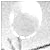

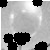

In [40]:
import statistics

#Median Filter
def median_filter(src, ksize):
    # 畳み込み演算をしない領域の幅
    # width of skip
    d = int((ksize-1)/2)
    h, w = src.shape[0], src.shape[1]

    # ndarray of destination
    # 出力画像用の配列（要素は入力画像と同じ）
    dst = src.copy()

    for y in range(d, h - d):
        for x in range(d, w - d):
            # 近傍にある画素値の中央値を出力画像の画素値に設定
            dst[y][x] = np.median(src[y-d:y+d+1, x-d:x+d+1])

    return dst

def make_sharp_kernel(k: int):
  return np.array([
    [-k / 9, -k / 9, -k / 9],
    [-k / 9, 1 + 8 * k / 9, k / 9],
    [-k / 9, -k / 9, -k / 9]
  ], np.float32)

kernel = make_sharp_kernel(1)
img = cv2.filter2D(img, -1, kernel).astype("uint8")

src_img_dir= '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename/030.jpg'

img = cv2.imread(src_img_dir,0)
x = int(trajectory_x[29])
y = int(trajectory_y[29])
h = w = 25

temp = img[y-h:y+h,x-w:x+w]
feature_params = dict( maxCorners = 10,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3 )

cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(255,0,0))
#cv2_imshow(img)
#////////

#old_gray = median_filter(temp, ksize=0)
#kernel = make_sharp_kernel(1)
old_gray = cv2.filter2D(temp, -1, kernel).astype("uint8")
cv2_imshow(old_gray)

#convert to a gray image
#old_gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
#cv2_imshow(old_gray)

#detect feature points by Shi-Tomashi method
#return : feature points :shape(num_points,2)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

#check feature points
for p in p0:
  x,y = p.ravel() #ravel():change from multi-dimensional array to 1-dimensional array
  cv2.circle(temp,(int(x),int(y)),5,(0,255,255),-1)
cv2_imshow(temp)

In [42]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import statistics


#Median Filter
def median_filter(src, ksize):
    # 畳み込み演算をしない領域の幅
    # width of skip
    d = int((ksize-1)/2)
    h, w = src.shape[0], src.shape[1]

    # ndarray of destination
    # 出力画像用の配列（要素は入力画像と同じ）
    dst = src.copy()

    for y in range(d, h - d):
        for x in range(d, w - d):
            # 近傍にある画素値の中央値を出力画像の画素値に設定
            dst[y][x] = np.median(src[y-d:y+d+1, x-d:x+d+1])

    return dst

def make_sharp_kernel(k: int):
  return np.array([
    [-k / 9, -k / 9, -k / 9],
    [-k / 9, 1 + 8 * k / 9, k / 9],
    [-k / 9, -k / 9, -k / 9]
  ], np.float32)

kernel = make_sharp_kernel(1)

#///// Setting ////////
src_img_dir= '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename'


src_files=glob.glob("{}/*.jpg".format(src_img_dir))
src_files.sort()
max = []
x_templ = []
y_templ = []
h = 30
w = 30
t = 0
t = 0
count = 0
error = []
x = None
y = None
num_yolo = 0
global_x = []
global_y = []

dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/optical_flow2'#ObjectTracking/20221221/1/cam_1/ColorTracking-TemplateMatching'
if not os.path.exists(dst_img_dir):
  os.makedirs(dst_img_dir)

# ///////////////////////////////////

# Optical Flow
#ap = cv2.VideoCapture('slow.flv')

#Feature Extraction Setting: Shi-Tomashi corner detection
# params for ShiTomasi corner detection
feature_params = dict( maxCorners =30,
                       qualityLevel = 0.01,
                       minDistance = 2,
                       blockSize = 2 )

#Setting for LK method
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (9,9),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
#ret, old_frame = cap.read()


for i,src in enumerate(src_files):
  print(i)
  dst_file = "{dir}/{index:03d}.jpg".format(dir=dst_img_dir,index=i+1)
  count += 1
  t1 = time.time()
  img = cv2.imread(src,0)

  #get object ROI from YOLO
  if num_yolo == 0:
    if i%5 == 0:
      if trajectory_x[i] != None:
        print("first YOLO")
        num_yolo += 1
        x = int(trajectory_x[i])
        y = int(trajectory_y[i])
        r = int(radius[i])
        old_gray = img[y-h:y+h,x-w:x+w]
        #Edge Filter
        #old_gray = median_filter(temp, ksize=3)
        #old_gray = cv2.filter2D(old_gray, -1, kernel).astype("uint8")
        #cv2_imshow(temp)
      else:
        print(None)
        global_x.append(None)
        global_y.append(None)
        
        
        cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
        #save images
        cv2.imwrite(dst_file,img)
        #cv2_imshow(img)
        
        continue
      
      global_x.append(x)
      global_y.append(y)
      
      
      #confirm searching area
      cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(0,0,255),thickness=3)
      cv2.circle(img,(x,y),5,color=(0,0,255),thickness=-1)
      cv2.putText(img, 'Object Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255), 2, cv2.LINE_AA)
      #save images
      cv2.imwrite(dst_file,img)
      #cv2_imshow(img)
      
      
      #/Object 

      #convert to a gray image
      #old_gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
      #cv2_imshow(old_gray)

      #detect feature points by Shi-Tomashi method
      #return : feature points :shape(num_points,2)
      p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
      
      #check feature points
      for p in p0:
        a,b = p.ravel() #ravel():change from multi-dimensional array to 1-dimensional array
        #cv2.circle(temp,(int(a),int(b)),5,(0,255,255),-1)
      #cv2_imshow(temp)
      #cv2_imshow(img)
      
    else:
      print(None)
      cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
      #save images
      cv2.imwrite(dst_file,img)
      #cv2_imshow(img)

      global_x.append(None)
      global_y.append(None)
  

  #not for the first time of YOLO detection
  else:
    if i%5 == 0:
      if trajectory_x[i] != None:
        print("YOLO again")
        num_yolo += 1
        x = int(trajectory_x[i])
        y = int(trajectory_y[i])
        #r = int(radius[i])
        old_gray = img[y-h:y+h,x-w:x+w]

        #Edge Filter
        #old_gray = median_filter(temp, ksize=3)
        #old_gray = cv2.filter2D(old_gray, -1, kernel).astype("uint8")
        #cv2_imshow(temp)
      
        global_x.append(x)
        global_y.append(y)
        
        
        #confirm searching area
        cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(0,0,255),thickness=3)
        cv2.circle(img,(x,y),5,color=(0,0,255),thickness=-1)
        cv2.putText(img, 'Object Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255), 2, cv2.LINE_AA)
        #cv2_imshow(img)

        #save images
        cv2.imwrite(dst_file,img)
        #////////

        #convert to a gray image
        #old_gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
        #cv2_imshow(old_gray)

        #detect feature points by Shi-Tomashi method
        #return : feature points :shape(num_points,2)
        p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
        
        #check feature points
        for p in p0:
          a,b = p.ravel() #ravel():change from multi-dimensional array to 1-dimensional array

          #cv2.circle(temp,(int(a),int(b)),5,(0,255,255),-1)
        #cv2_imshow(temp)
        # Create a mask image for drawing purposes
        #mask = np.zeros_like(old_gray)
        #cv2_imshow(mask)
        #next step
        continue

      #can't get new ROI frame from YOLO
      else:
        print("can't detect ROI from Yolo")
        #x,y; global coordination
        x = int(x)
        y = int(y)
        frame = img[y-h:y+h,x-w:x+w]
        frame = median_filter(frame, ksize=3)
        frame_gray = cv2.filter2D(frame, -1, kernel).astype("uint8")
        #calculate Optical Flow with Lucas-Kanade method
        #frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        #calcOpticalFlowPyrLK(previous image,current frame,position of previous image)
        #return ; 
        #p1: next 2D points, if OPTFLOW_USE_INITIAL_FLOW, return all corresponding points
        #st: if found, 1, else, 0
        #err: 
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params) 

        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]

        # draw the tracks
        #temp_mov_x = 0
        #temp_mov_y = 0
        #num_points = 0
        mov_x = []
        mov_y = []
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel() #new pos: (x,y)
            c,d = old.ravel() #previous pos: (x,y)
            
            mov_x.append(a-c)
            mov_y.append(b-d)
            #for average
            #temp_mov_x += (a-c)
            #temp_mov_y += (b-d)
            #num_points += 1
            #mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            #frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        #ave_mov_x = temp_mov_x/num_points
        #ave_mov_y = temp_mov_y/num_points
        
        mean_mov_x = statistics.median(mov_x)
        mean_mov_y = statistics.median(mov_y)

        #x,y; global coordination
        #x += ave_mov_x
        #y += ave_mov_y

        x += mean_mov_x
        y += mean_mov_y

        global_x.append(x)
        global_y.append(y)
        #img = cv2.add(frame,mask)
        #draw ROI & position
        x = int(x)
        y = int(y)
        
        cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
        cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(255,0,0),thickness=3)
        cv2.circle(img,(x,y),5,color=(255,0,0),thickness=-1)

        #save images
        cv2.imwrite(dst_file,img)
        #v2.circle(img,(int(x),int(y)),color = (255,0,0),thichness=-1)
        #cv2_imshow(img)
        #k = cv2.waitKey(30) & 0xff
        #if k == 27:
        #    break

        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()

        #translate points cause the frame translate
        temp_p0 = []
        for p in p0:
          a,b = p.ravel()
          #a -= ave_mov_x
          #b -= ave_mov_y
          
          a -= mean_mov_x
          b -= mean_mov_y

          temp_p0.append([a,b])
        p0 = np.asarray(temp_p0)
        p0 = good_new.reshape(-1,1,2)

    else:
      print("Optical flow")
      #x,y; global coordination
      x = int(x)
      y = int(y)
      frame_gray = img[y-h:y+h,x-w:x+w]
      #frame_gray = median_filter(frame, ksize=3)
      #frame_gray = cv2.filter2D(frame_gray, -1, kernel).astype("uint8")
      #cv2.circle(img,(x,y),3,color=(255,0,0),thickness=-1)
      #cv2_imshow(img)

      #calculate Optical Flow with Lucas-Kanade method
      #frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

      # calculate optical flow
      #calcOpticalFlowPyrLK(previous image,current frame,position of previous image)
      #return ; 
      #p1: next 2D points, if OPTFLOW_USE_INITIAL_FLOW, return all corresponding points
      #st: if found, 1, else, 0
      #err: 
      p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params) 

      # Select good points
      good_new = p1[st==1]
      good_old = p0[st==1]

      # draw the tracks
      #temp_mov_x = 0
      #temp_mov_y = 0
      #num_points = 0

      mov_x = []
      mov_y = []
      
      for i,(new,old) in enumerate(zip(good_new,good_old)):
          a,b = new.ravel() #new pos: (x,y)
          c,d = old.ravel() #previous pos: (x,y)
          
          #temp_mov_x += (a-c)
          #temp_mov_y += (b-d)
          #num_points += 1

          mov_x.append(a-c)
          mov_y.append(b-d)
          #mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
          #frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
      #ave_mov_x = temp_mov_x/num_points
      #ave_mov_y = temp_mov_y/num_points
      
      mean_mov_x = statistics.median(mov_x)
      mean_mov_y = statistics.median(mov_y)

      #print("average movement:(x::{},y::{}".format(ave_mov_x,ave_mov_y))
      #x,y; global coordination
      #print("before (x::{},y::{}".format(x,y))

      #x += ave_mov_x
      #y += ave_mov_y

      x += mean_mov_x
      y += mean_mov_y
      
      #print("after (x::{},y::{}".format(x,y))
      global_x.append(x)
      global_y.append(y)
      #img = cv2.add(frame,mask)
      x = int(x)
      y = int(y)
      cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(255,0,0),thickness=3)
      cv2.circle(img,(x,y),5,color=(255,0,0),thickness=-1)
      #cv2_imshow(img)
      #save images
      cv2.imwrite(dst_file,img)
      #k = cv2.waitKey(30) & 0xff
      #if k == 27:
      #    break

      # Now update the previous frame and previous points
      old_gray = frame_gray.copy()

      #translate points cause the frame translate
      temp_p0 = []
      for p in p0:
        a,b = p.ravel()
        
        #a -= ave_mov_x
        #b -= ave_mov_y

        a -= mean_mov_x
        b -= mean_mov_y

        temp_p0.append([a,b])
      p0 = np.asarray(temp_p0)
      p0 = good_new.reshape(-1,1,2)
  t2 = time.time()

  t += (t2-t1)

frequency = count/t
print("process time; {:.1f}".format(frequency))
  #print(global_x[-1])
#cv2.destroyAllWindows()
#cap.release()

0
None
1
None
2
None
3
None
4
None
5
None
6
None
7
None
8
None
9
None
10
first YOLO
11
Optical flow
12
Optical flow
13
Optical flow
14
Optical flow
15
YOLO again
16
Optical flow
17
Optical flow
18
Optical flow
19
Optical flow
20
YOLO again
21
Optical flow
22
Optical flow
23
Optical flow
24
Optical flow
25
YOLO again
26
Optical flow
27
Optical flow
28
Optical flow
29
Optical flow
30
YOLO again
31
Optical flow
32
Optical flow
33
Optical flow
34
Optical flow
35
YOLO again
36
Optical flow
37
Optical flow
38
Optical flow
39
Optical flow
40
YOLO again
41
Optical flow
42
Optical flow
43
Optical flow
44
Optical flow
45
YOLO again
46
Optical flow
47
Optical flow
48
Optical flow
49
Optical flow
50
YOLO again
51
Optical flow
52
Optical flow
53
Optical flow
54
Optical flow
55
YOLO again
56
Optical flow
57
Optical flow
58
Optical flow
59
Optical flow
60
YOLO again
61
Optical flow
62
Optical flow
63
Optical flow
64
Optical flow
65
YOLO again
66
Optical flow
67
Optical flow
68
Optical flow
69
Optical

In [43]:
error = []
count = 0
errors =[]
for i in range(len(global_x)):
  if global_x[i] != None and trajectory_x[i] != None:
    err = ((global_x[i]-trajectory_x[i])**2+(global_y[i]-trajectory_y[i])**2)**(1/2)
    error.append(err)
    errors.append(err)
    count+= 1
  else:
    error.append(None)
print(error)
ave = statistics.mean(errors)
print("average error:{:.1f} [pixel]".format(ave))

[None, None, None, None, None, None, None, None, None, None, 0.0, 6.072511183479338, 7.592054437888588, 15.918231770947306, 27.080471896884937, 0.0, 2.6703166966472303, 7.471307980990805, 8.278568024599831, 8.869214071363158, 0.0, 1.3809215378763273, 4.904606205938188, 0.7101694700855242, 5.8333719298645335, 0.0, 1.6836670318070042, 3.2369623192255346, 5.4168518536810515, 16.941528532071437, 0.0, 4.998301656660036, 11.634471322153829, 10.370228702933307, 19.411726130890063, 0.0, 1.7060276483834722, 7.4847457177384555, 15.125494080111627, 21.375974770800205, 0.0, 5.489235831966639, 9.489705145575956, 11.21591062283228, 17.468058540426277, 0.0, 0.8495967754621574, 3.2344907399677543, 4.679257798141786, 6.312645640903833, 0.0, 3.260013875295264, 6.070987571693733, 6.300403783153021, 9.76315458905167, 0.0, 0.857895849245544, 3.8579336437901133, 4.362526179763276, 9.868910979013014, 0.0, 1.9937684916538791, 2.256298219538167, 3.859641893582463, 6.359472792715038, 0.0, 6.555888620480591, 1.9

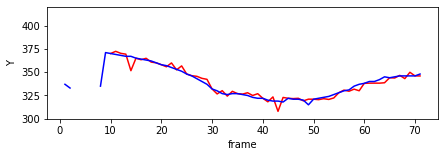

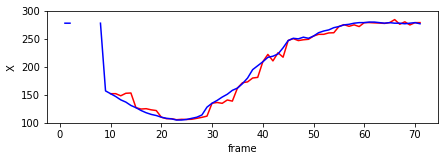

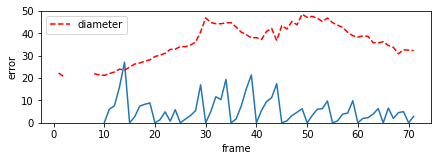

In [45]:
plt.subplots(figsize=(7,7))
plt.title("100Hz vs 1000 Hz")
plt.subplot(3,1,1)
plt.plot(global_x,color="r")
plt.plot(trajectory_x,color="b")
plt.xlabel('frame')
plt.ylabel('Y')
plt.ylim(300,420)
plt.show()
plt.subplots(figsize=(7,7))
plt.subplot(3,1,2)
plt.plot(global_y,color="r")
plt.plot(trajectory_y,color="b")
plt.xlabel('frame')
plt.ylabel('X')
plt.ylim(100,300)
plt.show()
plt.subplots(figsize=(7,7))
plt.subplot(3,1,3)
plt.plot(error)
plt.plot(radius,color='r',linestyle='--',label='diameter')
plt.xlabel('frame')
plt.ylabel('error')
plt.ylim(0,50)
plt.legend()
plt.show()

#YOLO+Templatematching

##IoU, ROI

In [67]:
def calculate_iou(bboxA,bboxB):
  """ calculate IoU(Intersection over Union)
  Input:
  bboxA, bboxB : ROI data [x_center,y_center,width,height]
  Return:
  Iou (Intersection over Union)
  """
  #bboxA edge point
  x_al = bboxA[0]-bboxA[2]/2
  y_al = bboxA[1]-bboxA[3]/2
  x_ar = bboxA[0]+bboxA[2]/2
  y_ar = bboxA[1]+bboxA[3]/2
  #bboxB edge point
  x_bl = bboxB[0]-bboxB[2]/2
  y_bl = bboxB[1]-bboxB[3]/2
  x_br = bboxB[0]+bboxB[2]/2
  y_br = bboxB[1]+bboxB[3]/2
  #intersection edge point
  x_il = max(x_al,x_bl)
  y_il = max(y_al,y_bl)
  x_ir = min(x_ar,x_br)
  y_ir = min(y_ar,y_br)

  #calculate intersection area
  S_i = max(0,x_ir-x_il+1)*max(0,y_ir-y_il+1)

  #calculate total area
  S_total = bboxA[2]*bboxA[3] + bboxB[2]*bboxB[3] - S_i

  IoU = S_i / S_total

  return IoU

def set_ROI(data,frame,idx):
  """setting ROI from YOLO
  Input:
  /data:trajectory of object {0:ball,1:hand,2:elbow,3:boody}
  /frame:frame list, here fram_0, frame_1, frame_2, frame_3
  /idx: frame index of detected object
  Return:
  if Detected:
    /x,y: center of ROI
    /w,h: wiidth, height of ROI
  else:
    /None,None,None,NOne

  """
  index = np.where(frame == idx)[0] #get index
  num_candidate = index.shape[0] # number of candidate
  candidate = data[index] # candidate ROI for updating, shape:(n,4) n:num of candidates

  #main loop of deciding ROI
  #if candidate is one
  if num_candidate == 1: 

    #If can't detect object:
    if candidate[0][0] == None:
        return None,None,None,None
    #Detected    
    else:
        return candidate[0][0],candidate[0][1],candidate[0][2],candidate[0][3] #x_center,y_center,width,height
  
  #if num of candidates are many or how to determine the reliability of the ROI -> future work : eg) BGS limit the searching area or considering the position constraints
  #else:


def get_ROI(data,frame,idx,old_frame,threshold):
  """Getting ROI from YOLO
  Input:
  /data:trajectory of object {0:ball,1:hand,2:elbow,3:boody}
  /frame:frame list, here fram_0, frame_1, frame_2, frame_3
  /idx: frame index of detected object
  /old_frame : previous ROI
  /threshold : IoU threshold
  Return:
  if IoU > threshold:
    /x,y: center of ROI
    /w,h: wiidth, height of ROI
  else:
    /old_frame ROI
  """


  index = np.where(frame == idx)[0] #get index
  num_candidate = index.shape[0] # number of candidate
  candidate = data[index] # candidate ROI for updating, shape:(n,4) n:num of candidates

  #main loop of deciding ROI
  #if candidate is one
  if num_candidate == 1: 

    #If can't detect object:
    if candidate[0][0] == None:
        return old_frame[0],old_frame[1],old_frame[2],old_frame[3]

    #Detected    
    else:
      IoU = calculate_iou(old_frame, candidate[0]) 
      if IoU > threshold : #adapt new ROI
        return candidate[0][0],candidate[0][1],candidate[0][2],candidate[0][3] #x_center,y_center,width,height
      else: #deny new ROI
        return old_frame[0],old_frame[1],old_frame[2],old_frame[3]

  #if candidates are more than 1
  elif num_candidate >= 2: 
    #determin most possible ROI
    temp_iou = []
    for i in range(num_candidate):
      iou = calculate_iou(old_frame, candidate[i])
      temp_iou.append(iou)
    index = np.argmax(temp_iou)
    IoU = temp_iou[index]

    #adapt new ROI
    if IoU > threshold : 
      return candidate[0][0],candidate[0][1],candidate[0][2],candidate[0][3] #x_center,y_center,width,height
    #deny new ROI
    else:
      return old_frame[0],old_frame[1],old_frame[2],old_frame[3]

In [ ]:
import time
template_x = []
template_y = []
num_yolo = 0
t = 0
threshold = 0.01


src_img_dir= '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/rename'
src_files=glob.glob("{}/*.jpg".format(src_img_dir))
src_files.sort()

dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/Ball'#ObjectTracking/20221221/1/cam_1/ColorTracking-TemplateMatching'
if not os.path.exists(dst_img_dir):
  os.makedirs(dst_img_dir)

for i,src in enumerate(src_files):
  print(i)
  dst_file = "{dir}/{index:03d}.jpg".format(dir=dst_img_dir,index=i)
  count += 1
  t1 = time.time()
  #read image as gray scale
  img = cv2.imread(src,0)

  #get object ROI from YOLO
  if num_yolo == 0:
    if (i-1)%5 == 0:
      x,y,w,h = set_ROI(Ball,frame_0,i)
      if x != None:
        print("first YOLO")
        num_yolo += 1
        template= img[int(y-h/2):int(y+h/2),int(x-w/2):int(x+w/2)]
        template_x.append(x)
        template_y.append(y)
        old_ROI = [x,y,w,h]
        #Search Area
        cv2.rectangle(img,(int(x-w),int(y-h)),(int(x+w),int(y+w)),color=125,thickness=3)
        cv2.rectangle(img,(int(x-w/2),int(y-h/2)),(int(x+w/2),int(y+w/2)),color=60,thickness=3)
        #cv2_imshow(temp)
      else:
        print(None)
        template_x.append(None)
        template_y.append(None)
        
        
        cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
        #save images
        cv2.imwrite(dst_file,img)
        #cv2_imshow(img)
        
        continue
      
      """
      #confirm searching area
      cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(0,0,255),thickness=3)
      cv2.circle(img,(x,y),5,color=(0,0,255),thickness=-1)
      cv2.putText(img, 'Object Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255), 2, cv2.LINE_AA)
      #save images
      cv2.imwrite(dst_file,img)
      #cv2_imshow(img)
      """
      
    
    #Can't get ROI when there is no ROI detection
    else:
      print(None)
      """
      cv2.putText(img, 'Object can\'t be Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_AA)
      #save images
      cv2.imwrite(dst_file,img)
      #cv2_imshow(img)
      """

      template_x.append(None)
      template_y.append(None)
  

  #not for the first time of YOLO detection
  else:
    if (i-1)%5 == 0:
      x,y,w,h = get_ROI(Ball,frame_0,i,old_ROI,threshold)
      if x != None:
        print("YOLO again")
        num_yolo += 1
        #old_gray : searning area
        template = img[int(y-h/2):int(y+h/2),int(x-w/2):int(x+w/2)]
        #Search Area
        cv2.rectangle(img,(int(x-w),int(y-h)),(int(x+w),int(y+w)),color=125,thickness=3)
        cv2.rectangle(img,(int(x-w/2),int(y-h/2)),(int(x+w/2),int(y+w/2)),color=60,thickness=3)
        #cv2_imshow(temp)
      
        template_x.append(x)
        template_y.append(y)
        
        """
        #confirm searching area
        cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(0,0,255),thickness=3)
        cv2.circle(img,(x,y),5,color=(0,0,255),thickness=-1)
        cv2.putText(img, 'Object Detected', (0, 40), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255), 2, cv2.LINE_AA)
        #cv2_imshow(img)

        #save images
        cv2.imwrite(dst_file,img)
        #////////
        """
        #convert to a gray image
        old_ROI = [x,y,w,h]
        #cv2_imshow(old_gray)

      #can't get new ROI frame from YOLO
      else:
        print("can't detect ROI from Yolo")
        print('TemplateMatching')
        #x,y; global coordination
        search_area = img[int(y-h):int(y+h),int(x-w):int(x+w)]
        #Search Area
        cv2.rectangle(img,(int(x-w),int(y-h)),(int(x+w),int(y+w)),color=125,thickness=3)
        cv2.rectangle(img,(int(x-w/2),int(y-h/2)),(int(x+w/2),int(y+w/2)),color=60,thickness=3)
        #cv2_imshow(search_area)
        #cv2.circle(img,(x,y),3,color=(255,0,0),thickness=-1)
        #cv2_imshow(img)

        #テンプレートマッチング（OpenCVで実装）
        #match = cv2.matchTemplate(gray, temp, cv2.TM_CCOEFF_NORMED)
        match = cv2.matchTemplate(search_area,template, cv2.TM_CCOEFF_NORMED) #match : heatmap of similarity 
        min_value, max_value, min_pt, max_pt = cv2.minMaxLoc(match)
        pt = max_pt # (x,y), uppper-left point
        x_left = pt[0]+x-w
        y_left = pt[1]+y-h
        
        x_center = x_left+w/2
        y_center = y_left+h/2
        template_x.append(x_center)
        template_y.append(y_center)
        old_ROI = [x_center,y_center,w,h]
        template = img[int(y_center-h/2):int(y_center+h/2),int(x_center-w/2):int(x_center+w/2)]
        #dst_file = "{dir}/{index:03d}.jpg".format(dir=dst_img_dir,index=i+1)
        #cv2.imwrite(dst_file,img)


        """
          cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(255,0,0),thickness=3)
          cv2.circle(img,(x,y),5,color=(255,0,0),thickness=-1)
          #cv2_imshow(img)
          #save images
          cv2.imwrite(dst_file,img)
        """
  

    #TemplateMatching
    else:
      print("Template Matching")
      #x,y; global coordination
      search_area = img[int(y-h):int(y+h),int(x-w):int(x+w)]
      #Search Area
      cv2.rectangle(img,(int(x-w),int(y-h)),(int(x+w),int(y+w)),color=125,thickness=3)
      cv2.rectangle(img,(int(x-w/2),int(y-h/2)),(int(x+w/2),int(y+w/2)),color=60,thickness=3)
      #cv2_imshow(search_area)
      #cv2.circle(img,(x,y),3,color=(255,0,0),thickness=-1)
      #cv2_imshow(img)

      #テンプレートマッチング（OpenCVで実装）
      #match = cv2.matchTemplate(gray, temp, cv2.TM_CCOEFF_NORMED)
      match = cv2.matchTemplate(search_area,template, cv2.TM_CCOEFF_NORMED) #match : heatmap of similarity 
      min_value, max_value, min_pt, max_pt = cv2.minMaxLoc(match)
      pt = max_pt # (x,y), uppper-left point
      x_left = pt[0]+x-w
      y_left = pt[1]+y-h
      
      x_center = x_left+w/2
      y_center = y_left+h/2
      template_x.append(x_center)
      template_y.append(y_center)
      old_ROI = [x_center,y_center,w,h]
      template = img[int(y_center-h/2):int(y_center+h/2),int(x_center-w/2):int(x_center+w/2)]
      #dst_file = "{dir}/{index:03d}.jpg".format(dir=dst_img_dir,index=i+1)
      #cv2.imwrite(dst_file,img)


    
    #cv2.rectangle(img,(x-w,y-h),(x+w,y+h),color=(255,0,0),thickness=3)
    #cv2.circle(img,(x,y),5,color=(255,0,0),thickness=-1)
    #cv2_imshow(img)
    #save images
    dst_file = "{dir}/{index:03d}.jpg".format(dir=dst_img_dir,index=i)
    cv2.imwrite(dst_file,img)
  
  t2 = time.time()

  t += (t2-t1)
  #cv2_imshow(img)
frequency = count/t
print("process time; {:.1f}".format(frequency))

#Evaluating Ball tracking

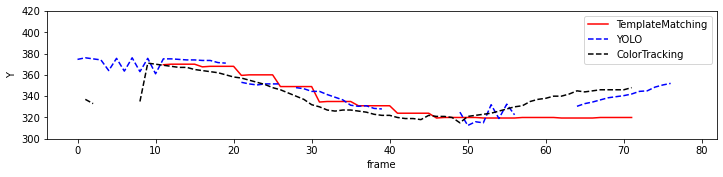

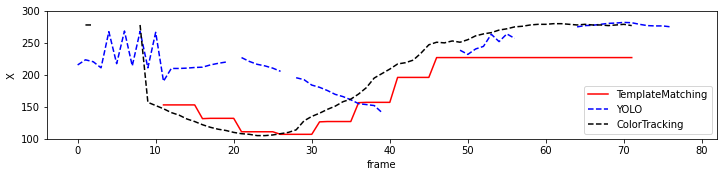

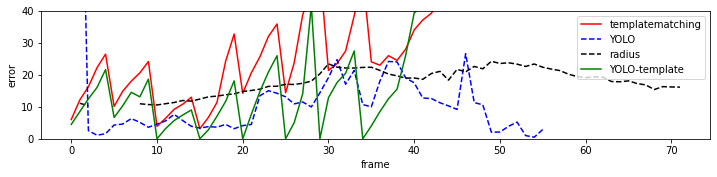

Error
Template-Color::32.36 pixel
YOLO-Color::13.03 pixel
Template-YOLO::13.03 pixel


In [ ]:
from pandas.core.indexing import convert_from_missing_indexer_tuple
import statistics
#calculate error
error_template = []
error_YOLO = []
error_YOLO_template = []
for i in range(len(template_x)):
  if template_x[i] != None and trajectory_x[i] != None:
    err = ((template_x[i]-trajectory_x[i])**2+(template_y[i]-trajectory_y[i])**2)**(1/2)
    error_template.append(err)
    
  #else:
  #  error_template.append(None)

  if Ball[i,0] != None and trajectory_x[i] != None:
    err = ((Ball[i,0]-trajectory_x[i])**2+(Ball[i,1]-trajectory_y[i])**2)**(1/2)
    error_YOLO.append(err)
  #else:
  #  error_YOLO.append(None)

  if Ball[i,0] != None and template_x[i] != None:
    err = ((Ball[i,0]-template_x[i])**2+(Ball[i,1]-template_y[i])**2)**(1/2)
    error_YOLO_template.append(err)
  #else:
  #  error_YOLO_template.append(None)
for i in range(len(radius)):
  if radius[i] != None:
    r = radius[i]
    radius[i] = r

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(template_x,color="r",label="TemplateMatching")
plt.plot(Hand[:,0],color="b",linestyle="--",label="YOLO")
plt.plot(trajectory_x,color="k",linestyle="--",label="ColorTracking")
plt.xlabel('frame')
plt.ylabel('Y')
plt.ylim(300,420)
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
plt.subplot(3,1,2)
plt.plot(template_y,color="r",label="TemplateMatching")
plt.plot(Hand[:,1],color="b",linestyle="--",label="YOLO")
plt.plot(trajectory_y,color="k",linestyle="--",label="ColorTracking")
plt.xlabel('frame')
plt.ylabel('X')
plt.ylim(100,300)
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
plt.subplot(3,1,3)
plt.plot(error_template,color='r',label="templatematching")
plt.plot(error_YOLO,color='b',linestyle='--',label="YOLO")
plt.plot(radius,color='k',linestyle='--',label='radius')
plt.plot(error_YOLO_template,color="g",label="YOLO-template")
plt.xlabel('frame')
plt.ylabel('error')
plt.ylim(0,40)
plt.legend()
plt.show()

error_Template_Color = statistics.mean(error_template)
error_YOLO_Color = statistics.mean(error_YOLO)
error_Template_YOLO = statistics.mean(error_YOLO)

print('Error\nTemplate-Color::{:.2f} pixel\nYOLO-Color::{:.2f} pixel\nTemplate-YOLO::{:.2f} pixel'.format(error_Template_Color,error_YOLO_Color,error_Template_YOLO))

#Evaluating Hand, Elbow, Body

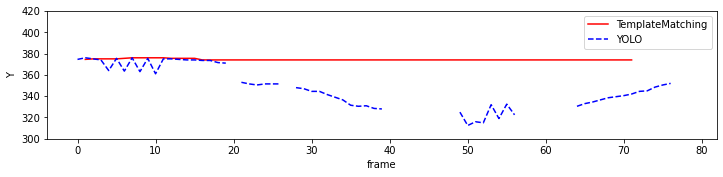

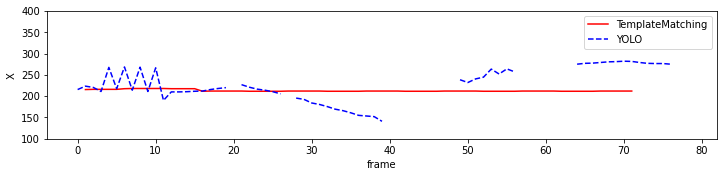

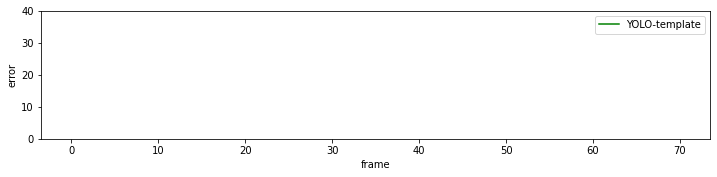

Error
Template-YOLO::91.01 pixel


In [ ]:
from pandas.core.indexing import convert_from_missing_indexer_tuple
import statistics
#calculate error
#error_template = []
#error_YOLO = []
error_YOLO_template = []
for i in range(len(template_x)):
  
  if Body[i,0] != None and template_x[i] != None:
    err = ((Body[i,0]-template_x[i])**2+(Body[i,1]-template_y[i])**2)**(1/2)
    error_YOLO_template.append(err)
  #else:
  #  error_YOLO_template.append(None)
for i in range(len(radius)):
  if radius[i] != None:
    r = radius[i]
    radius[i] = r

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(template_x,color="r",label="TemplateMatching")
plt.plot(Hand[:,0],color="b",linestyle="--",label="YOLO")
plt.xlabel('frame')
plt.ylabel('Y')
plt.ylim(300,420)
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
plt.subplot(3,1,2)
plt.plot(template_y,color="r",label="TemplateMatching")
plt.plot(Hand[:,1],color="b",linestyle="--",label="YOLO")
plt.xlabel('frame')
plt.ylabel('X')
plt.ylim(100,400)
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
plt.subplot(3,1,3)
plt.plot(error_YOLO_template,color="g",label="YOLO-template")
plt.xlabel('frame')
plt.ylabel('error')
plt.ylim(0,40)
plt.legend()
plt.show()

error_Template_YOLO = statistics.mean(error_YOLO_template)

print('Error\nTemplate-YOLO::{:.2f} pixel'.format(error_Template_YOLO))

#ColorTracking＋TemplateMatching

average error:3.2 [pixel]


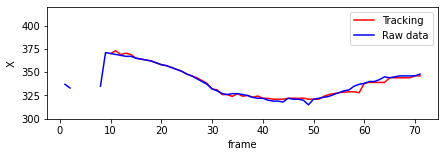

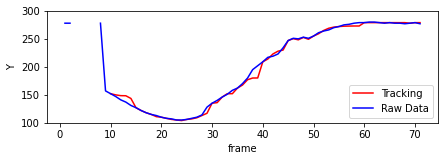

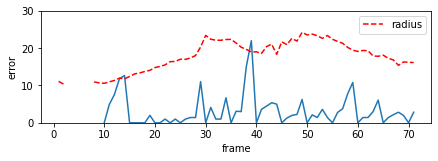

In [ ]:
errors = []
errors_plot = []
for i in range(len(X)): #8.0 pixel, exclude outlier :3.9 pixel
  if X[i] != None:
    err = error(trajectory_x[i],trajectory_y[i],X[i],Y[i])
    errors.append(err)
    errors_plot.append(err)
  else:
    errors_plot.append(None)
ave = statistics.mean(errors)

print("average error:{:.1f} [pixel]".format(ave))

plt.figure(figsize=(7,7))
#plt.title("100Hz vs 1000 Hz")
plt.subplot(3,1,1)
plt.plot(X,color="r",label="Tracking")
plt.plot(trajectory_x,color="b",label="Raw data")
plt.xlabel('frame')
plt.ylabel('X')
plt.ylim(300,420)
plt.legend()
plt.show()
plt.figure(figsize=(7,7))
plt.subplot(3,1,2)
plt.plot(Y,color="r",label='Tracking')
plt.plot(trajectory_y,color="b",label='Raw Data')
plt.xlabel('frame')
plt.ylabel('Y')
plt.ylim(100,300)
plt.legend()
plt.show()
plt.figure(figsize=(7,7))
plt.subplot(3,1,3)
plt.plot(errors_plot)
plt.plot(radius,color='r',linestyle='--',label='radius')
plt.xlabel('frame')
plt.ylabel('error')
plt.ylim(0,30)
plt.legend()
plt.show()

#20221221/3 data

##approximate by parabola

In [ ]:
import numpy as np
from numpy.linalg import solve

In [ ]:
# 任意の3点から2次関数を決定する関数
# 引数     ：任意の3点A(x1, y1), B(x2, y2), C(x3, y3)
# 戻り値   ：y = ax **2 + bx + c の [a, b, c]

import time 

def DecisionQuadraticFunc(x1:int, y1:int, x2:int, y2:int, x3:int, y3:int) -> list:
    # 3元1次連立方程式を解く
    left_equation = np.array([[x1 ** 2, x1, 1], [x2 ** 2, x2, 1], [x3 ** 2, x3, 1]])
    right_equation = np.array([y1, y2, y3])

    result_data = solve(left_equation, right_equation)
    return result_data

def linear_approx(x1:int, y1:int, x2:int, y2:int) -> list:
    # 3元1次連立方程式を解く
    left_equation = np.array([[x1, 1], [x2, 1]])
    right_equation = np.array([y1, y2])

    result_data = solve(left_equation, right_equation)

    return result_data

# グラフを作成する関数
def MakeGraph(result_data:list):#, x1:int, y1:int, x2:int, y2:int, x3:int, y3:int) -> None:

    # 初期値をセット
    a = result_data[0]
    b = result_data[1]
    c = result_data[2]

    ########## 2次関数をグラフに図示 ##########
    # 2次関数のxを便宜上、0.1間隔で　-3 < x < 4 の範囲を指定
    xmin = 20
    xmax = 40
    xinterval = 0.1
    x = np.arange(xmin, xmax, xinterval)

    # yを算出
    y = a * (x ** 2) + b * x + c

    # グラフを作成
    plt.plot(x,y,linestyle='--',label='approx1')

# グラフを作成する関数
def MakeGraph_2(result_data:list):#, x1:int, y1:int, x2:int, y2:int, x3:int, y3:int) -> None:

    # 初期値をセット
    a = result_data[0]
    b = result_data[1]
    c = result_data[2]

    ########## 2次関数をグラフに図示 ##########
    # 2次関数のxを便宜上、0.1間隔で　-3 < x < 4 の範囲を指定
    xmin = 40
    xmax = 55
    xinterval = 0.1
    x = np.arange(xmin, xmax, xinterval)

    # yを算出
    y = a * (x ** 2) + b * x + c

    # グラフを作成
    plt.plot(x,y,linestyle='--',label='approx2')

# グラフを作成する関数:線形関数
def MakeGraph_linear(result_data:list):#, x1:int, y1:int, x2:int, y2:int, x3:int, y3:int) -> None:

    # 初期値をセット
    a = result_data[0]
    b = result_data[1]


    ########## 2次関数をグラフに図示 ##########
    # 2次関数のxを便宜上、0.1間隔で　-3 < x < 4 の範囲を指定
    xmin = 15
    xmax = 30
    xinterval = 1
    x = np.arange(xmin, xmax, xinterval)

    # yを算出
    y = a * x + b

    # グラフを作成
    plt.plot(x,y,linestyle='--',label='linear approx')

2739
[   -3.21666667   196.28333333 -2714.5       ]


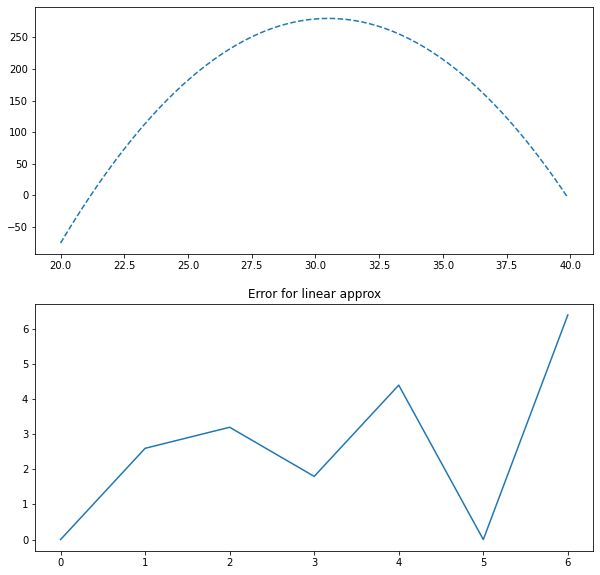

In [ ]:
t1 = time.time()
result = DecisionQuadraticFunc(30,trajectory_x[30],35,trajectory_x[35],39,trajectory_x[39])
y = result[0]*3**2+result[1]*3+result[2]
t2  = time.time()
print(int(1/(t2-t1)))
print(result)
plt.subplots(figsize=(10,10))
plt.subplot(2,1,1)
MakeGraph(result)
result_2 = DecisionQuadraticFunc(43,trajectory_x[43],45,trajectory_x[45],47,trajectory_x[47])
result_linear = linear_approx(20,trajectory_x[20],25,trajectory_x[25])

errors = []
for i in range(20,27):
  err = abs(trajectory_x[i]-(result_linear[0]*i+result_linear[1]))
  errors.append(err)
plt.subplot(2,1,2)
plt.title("Error for linear approx")
plt.plot(errors)

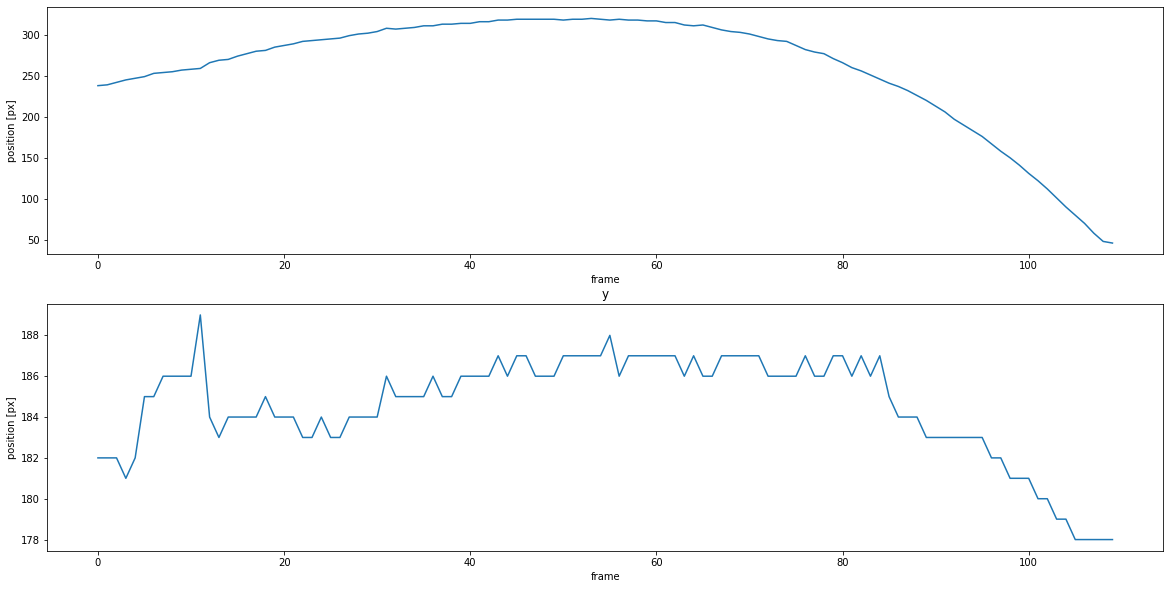

In [ ]:
num = []
for i in range(len(trajectory_x)):
  num.append(i)
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.xlabel('frame')
plt.ylabel('position [px]')
plt.plot(num,trajectory_x,label='tracking')
plt.subplot(2,1,2)
plt.xlabel('frame')
plt.ylabel('position [px]')
plt.title('y')
plt.plot(num,trajectory_y)

#Making Video From Images

In [ ]:
#処理後の画像を動画に変換する
import glob

#dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/cam_1/Processed'
#dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/calibrate'
#dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/1/cam_1/ColorTracking-TemplateMatching'
#dst_img_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/opticalFlow'
#dst_img_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/color_tracking/'
dst_img_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/Body'
#dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/color_template_tracking'#ObjectTracking/20221221/1/cam_1/ColorTracking-TemplateMatching'
src_img_dir=dst_img_dir

#フォルダに存在するファイルを取得する、0001.jpg~0005.jpg→{}/*.jpg
src_files=glob.glob("{}/*.jpg".format(src_img_dir))
src_files.sort()

#処理後の画像から動画を作る
!ffmpeg -framerate 10 -i "$src_img_dir/%03d.jpg" '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/Body.mp4' #"/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/1/color-template.mp4"

Text(0.5, 1.0, 'radius from circumference')

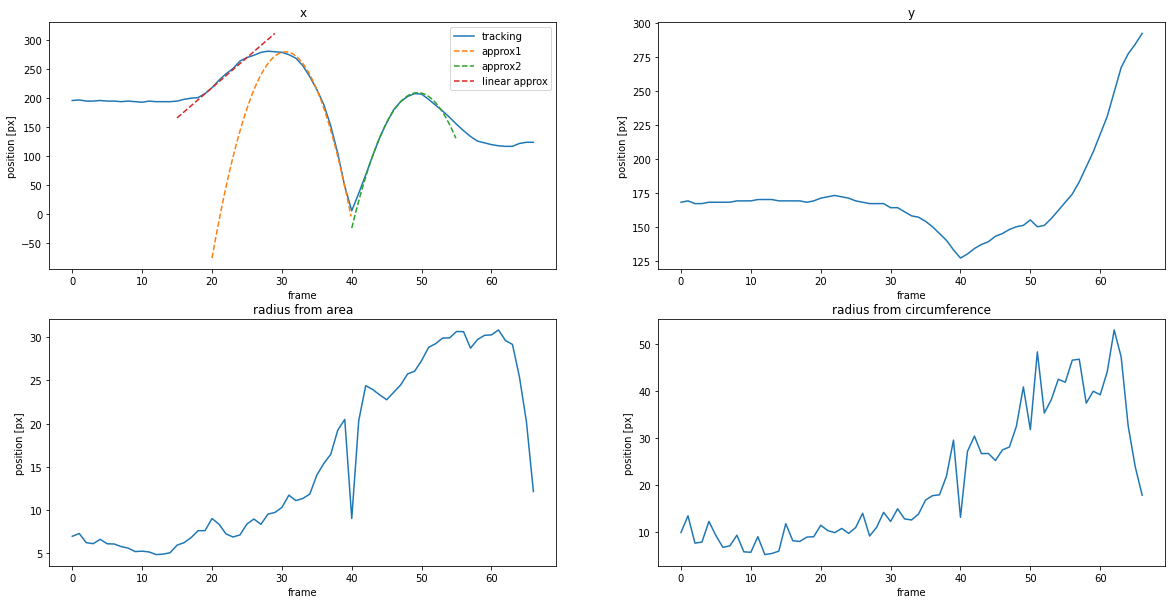

In [ ]:
num = []
for i in range(len(trajectory_x)):
  num.append(i)
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.xlabel('frame')
plt.ylabel('position [px]')
plt.plot(num,trajectory_x,label='tracking')
MakeGraph(result)
MakeGraph_2(result_2)
MakeGraph_linear(result_linear)
plt.legend()
plt.title('x')
plt.subplot(2,2,2)
plt.xlabel('frame')
plt.ylabel('position [px]')
plt.title('y')
plt.plot(num,trajectory_y)
plt.subplot(2,2,3)
plt.plot(num,radius)
plt.xlabel('frame')
plt.ylabel('position [px]')
plt.title('radius from area')
plt.subplot(2,2,4)
plt.plot(num,radius2)
plt.xlabel('frame')
plt.ylabel('position [px]')
plt.title('radius from circumference')

#Kalmanfilter: predict ball position

In [ ]:
import cv2
import numpy as np


class KalmanFilter:
    kf = cv2.KalmanFilter(4, 2)
    kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    kf.processNoiseCov = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],np.float32) * 0.45

    def predict(self, coordX, coordY):
        ''' This function estimates the position of the object'''
        measured = np.array([[np.float32(coordX)], [np.float32(coordY)]])
        self.kf.correct(measured)
        predicted = self.kf.predict()
        x, y = int(predicted[0]), int(predicted[1])
        return x, y

In [ ]:
print(cv2.KalmanFilter.__doc__)

None


#predicte step by step

method 1

In [ ]:
kf = KalmanFilter()

predicted_x = []
predicted_y = []
num_yolo = 0
for i in range(len(trajectory_x)):
  print(i)
  #Not detect data
  if num_yolo == 0:
    if i%2 == 0:
      if trajectory_x[i] == None:
        print("not detected")
        predicted_x.append(None)
        predicted_y.append(None)
      else:
        print("First detected")
        predicted_x.append(trajectory_x[i])
        predicted_y.append(trajectory_y[i])
        num_yolo += 1
    else:
      print("Not detected")
      predicted_x.append(None)
      predicted_y.append(None)
  #prediction from detected data or estimated data
  else:
    if i%2 == 0:
      #object detected
      if trajectory_x[i] != None:
        print("Detected again")
        predicted_x.append(trajectory_x[i])
        predicted_y.append(trajectory_y[i])
      #object can't be detected
      else:
        print("Not Detected, so estimate")
        predicted = kf.predict(predicted_x[i-1],predicted_y[i-1])
        if predicted[0]-predicted_x[i-1]<30.0 or predicted[1]-predicted_y[i-1]<30.0:
          predicted_x.append(predicted[0])
          predicted_y.append(predicted[1])
        else:
          predicted_x.append(predicted_x[i-1])
          predicted_y.append(predicted_y[i-1])
    else:
      if predicted_x[i-1] != None and predicted_y[i-1] != None:
        print("Estimate with Kalman filter")
        predicted = kf.predict(predicted_x[i-1],predicted_y[i-1])
        if predicted[0]-predicted_x[i-1]<30.0 or predicted[1]-predicted_y[i-1]<30.0:
          predicted_x.append(predicted[0])
          predicted_y.append(predicted[1])
        else:
          predicted_x.append(predicted_x[i-1])
          predicted_y.append(predicted_y[i-1])


0
not detected
1
Not detected
2
First detected
3
Estimate with Kalman filter
4
Detected again
5
Estimate with Kalman filter
6
Not Detected, so estimate
7
Estimate with Kalman filter
8
Detected again
9
Estimate with Kalman filter
10
Detected again
11
Estimate with Kalman filter
12
Detected again
13
Estimate with Kalman filter
14
Detected again
15
Estimate with Kalman filter
16
Detected again
17
Estimate with Kalman filter
18
Detected again
19
Estimate with Kalman filter
20
Detected again
21
Estimate with Kalman filter
22
Detected again
23
Estimate with Kalman filter
24
Detected again
25
Estimate with Kalman filter
26
Detected again
27
Estimate with Kalman filter
28
Detected again
29
Estimate with Kalman filter
30
Detected again
31
Estimate with Kalman filter
32
Detected again
33
Estimate with Kalman filter
34
Detected again
35
Estimate with Kalman filter
36
Detected again
37
Estimate with Kalman filter
38
Detected again
39
Estimate with Kalman filter
40
Detected again
41
Estimate with K

method2

In [ ]:
from operator import length_hint
import numpy as np
#define parameters
dt = 0.025 #計測間隔
num = 10 #sequential input

def kalman_filter(P,num,predicted_x,predicted_y,dt = 0.025):
    
    #define measurements
    measurements=[]
    #define init matrix
    u = np.array([[0.], [0.], [0.], [0.]]) # 外部要素

    P = np.array([[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 100., 0.], [0., 0., 0., 100.]]) # 共分散行列
    F = np.array([[1., 0., dt, 0.], [0., 1., 0., dt], [0., 0., 1., 0.], [0., 0., 0., 1.]])  # 状態遷移行列
    H = np.array([[1., 0., 0, 0], [0., 1., 0., 0.]])  # 観測行列
    R = np.array([[0.1, 0], [0, 0.1]]) #ノイズ

    #define init velocity
    if len(predicted_x) == num:
      v_init = [0.0,0.0]
    else:
      vx = predicted_x[-num]-predicted_x[-num-1]
      vy = predicted_y[-num]-predicted_y[-num-1]
      v_init = [vx,vy]

    for i in range(num):
      measurements.append([predicted_x[-num+i],predicted_y[-num+i]])
    initial_xy = measurements[0]
    print(([[initial_xy[0]], [initial_xy[1]], [v_init[0]], [v_init[1]]]))
    x = np.array([[initial_xy[0]], [initial_xy[1]], [v_init[0]], [v_init[1]]]) # 初期位置と初期速度を代入した「4次元状態」

    I = np.identity((len(x)))    # 4次元単位行列

    for n in range(len(measurements)):       

        # 予測
        x = np.dot(F, x) + u
        P = np.dot(np.dot(F, P), F.T)

        # 計測更新
        Z = np.array([measurements[n]])
        y = Z.T - np.dot(H, x)
        S = np.dot(np.dot(H, P), H.T) + R
        K = np.dot(np.dot(P, H.T), np.linalg.inv(S))
        x = x + np.dot(K, y)        
        P = np.dot((I - np.dot(K, H)), P)

    x = x.tolist()
    P = P.tolist()
    return x,P


predicted_x = []
predicted_y = []
num_yolo = 0

def length(data):
  count = 0
  for i in range(len(data)):
    if data[i] != None:
      count+=1
  return count

for i in range(len(trajectory_x)):
  print(i)
  #Not detect data
  if num_yolo == 0:
    if i%5 == 0:
      if trajectory_x[i] == None:
        print("not detected")
        predicted_x.append(None)
        predicted_y.append(None)
      else:
        print("First detected")
        predicted_x.append(trajectory_x[i])
        predicted_y.append(trajectory_y[i])
        num_yolo += 1
    else:
      print("Not detected")
      predicted_x.append(None)
      predicted_y.append(None)
  #prediction from detected data or estimated data
  else:
    if i%5 == 0:
      #object detected
      if trajectory_x[i] != None:
        print("Detected again")
        predicted_x.append(trajectory_x[i])
        predicted_y.append(trajectory_y[i])
      #object can't be detected
      else:
        if length(predicted_x)<=num:
          predicted_x.append(trajectory_x[i])
          predicted_y.append(trajectory_y[i])
        else:
          print("Not Detected, so estimate")
          x,P = kalman_filter(P,num,predicted_x,predicted_y,dt = dt)
          if x[0][0] - predicted_x[i-1] < 100.0 or x[1][0] - predicted_y[i-1] < 100.0:
            predicted_x.append(x[0][0])
            predicted_y.append(x[1][0])
          else:
            predicted_x.append(predicted_x[i-1])
            predicted_y.append(predicted_y[i-1])
    else:
      if length(predicted_x)<=num:
        predicted_x.append(trajectory_x[i])
        predicted_y.append(trajectory_y[i])
      else:
        #if predicted_x[i-1] != None and predicted_y[i-1] != None:
        print("Estimate with Kalman filter")
        x,P = kalman_filter(P,num,predicted_x,predicted_y,dt =0.25)
        if x[0][0] - predicted_x[i-1] < 100.0 or x[1][0] - predicted_y[i-1] < 100.0:
          predicted_x.append(x[0][0])
          predicted_y.append(x[1][0])
        else:
          predicted_x.append(predicted_x[i-1])
          predicted_y.append(predicted_y[i-1])

print("6回の計測後の位置と速度の予測値：",kalman_filter(x, P)[0])

0
not detected
1
Not detected
2
Not detected
3
not detected
4
Not detected
5
Not detected
6
not detected
7
Not detected
8
Not detected
9
First detected
10
11
12
Detected again
13
14
15
Detected again
16
17
18
Detected again
19
20
Estimate with Kalman filter
[[370], [152], [-1], [-5]]
21
Detected again
22
Estimate with Kalman filter
[[368], [141], [-1], [-6]]
23
Estimate with Kalman filter
[[367], [137], [-1], [-4]]
24
Detected again
25
Estimate with Kalman filter
[[365], [127], [-2], [-4]]
26
Estimate with Kalman filter
[[364], [122], [-1], [-5]]
27
Detected again
28
Estimate with Kalman filter
[[362], [115], [-1], [-3]]
29
Estimate with Kalman filter
[[360], [113], [-2], [-2]]
30
Detected again
31
Estimate with Kalman filter
[[357], [108], [-4.298959004301139], [-3.4037650383360756]]
32
Estimate with Kalman filter
[[359.0831402081657], [106.47182156962373], [2.0831402081656734], [-1.528178430376272]]
33
Detected again
34
Estimate with Kalman filter
[[351], [105], [-7.382671736137354],

TypeError: ignored

In [ ]:
print(len(predicted_x))

72


In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.xlabel('frame')
plt.ylabel('position [px]')
plt.plot(trajectory_x,label='tracking')
plt.plot(predicted_x,label='kalmanfilter')
plt.legend()
plt.title('x')
plt.subplot(2,2,2)
plt.xlabel('frame')
plt.ylabel('position [px]')
plt.title('y')
plt.plot(trajectory_y,label='tracking')
plt.plot(predicted_y,label='kalmanfilter')

#predict from first 20 frames

In [ ]:
count = 0

kf = KalmanFilter()
predicted_x = []
predicted_y = []

for i in range(len(trajectory_x)):
  print(count)
  if trajectory_x[i] != None and trajectory_y[i] != None:
    if count < 45:
      predicted = kf.predict(trajectory_x[i],trajectory_y[i])
      predicted_x.append(predicted[0])
      predicted_y.append(predicted[1])
    elif count >= 45:
      predicted = kf.predict(predicted_x[-1],predicted_y[-1])
      predicted_x.append(predicted[0])
      predicted_y.append(predicted[1])
    count += 1

#calculate error

In [ ]:
err_x = []
err_y = []
for i in range(len(predicted_x)):
  er_x = abs(predicted_x[i]-trajectory_x[i])
  er_y = abs(predicted_y[i]-trajectory_y[i])
  err_x.append(er_x)
  err_y.append(er_y)

Plot

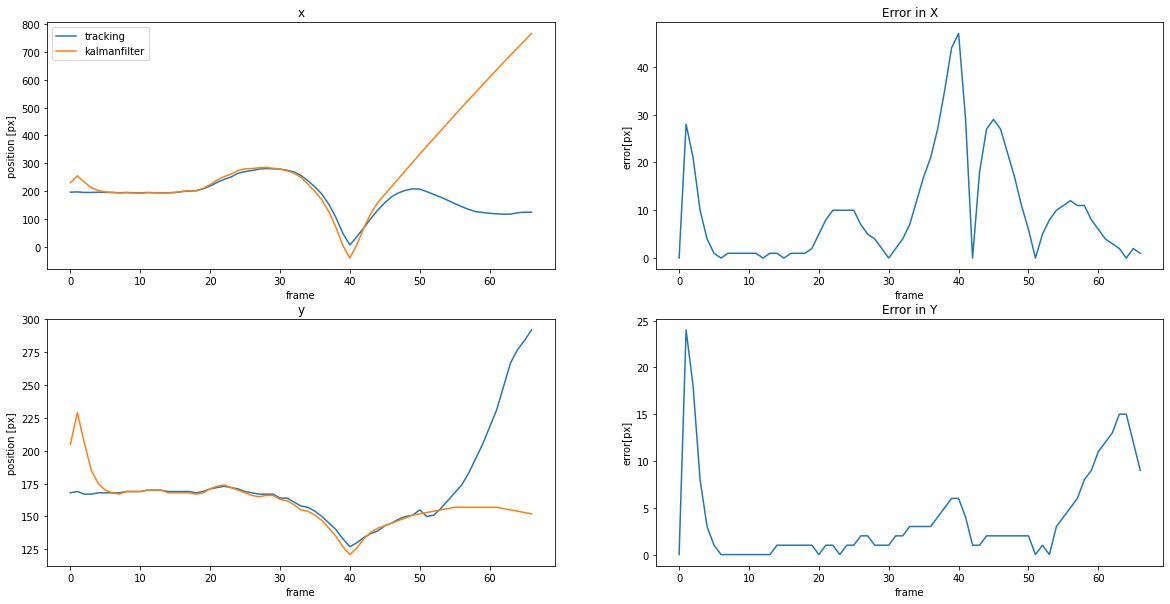

In [ ]:
num = []
for i in range(len(trajectory_x)):
  num.append(i)
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.xlabel('frame')
plt.ylabel('position [px]')
plt.plot(num,trajectory_x,label='tracking')
plt.plot(predicted_x,label='kalmanfilter')
plt.legend()
plt.title('x')
plt.subplot(2,2,2)
plt.title('Error in X')
plt.xlabel('frame')
plt.ylabel('error[px]')
plt.plot(err_x)
plt.subplot(2,2,3)
plt.xlabel('frame')
plt.ylabel('position [px]')
plt.title('y')
plt.plot(num,trajectory_y,label='tracking')
plt.plot(predicted_y,label='kalmanfilter')
plt.subplot(2,2,4)
plt.title('Error in Y')
plt.xlabel('frame')
plt.ylabel('error[px]')
plt.plot(err_y)

#Confirm weather I can capture in streo-parallized way

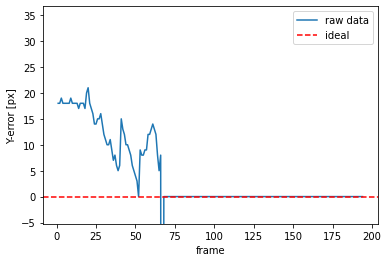

In [ ]:
import pandas as pd
#training data
cam_0=pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/cam_0/xydata.csv")
cam_1=pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/cam_1/xydata.csv")
cam_0x = cam_0.values[:,1]
cam_1x = cam_1.values[:,1]
diff = []
step = []
for i in range(len(cam_0x)):
  step.append(i+1)
  err = cam_0x[i]-cam_1x[i]
  diff.append(err)


plt.plot(step,diff,label='raw data')
plt.axhline(0,label='ideal',color='r',linestyle='--')
plt.xlabel('frame')
plt.ylim((-5.25))
plt.ylabel('Y-error [px]')
plt.legend()

In [ ]:
print(cam_1x)

[195 195 195 195 195 194 194 194 194 194 193 194 194 194 194 195 197 200
 200 209 218 230 242 253 262 269 274 279 281 280 279 275 269 256 237 216
 189 152 105  48   6  36  68 101 133 158 180 194 203 208 207 200 188 179
 167 155 143 134 126 123 120 118 117 117 123 124 125   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]


In [ ]:
#training data
file1=pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/1.csv")
file2=pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/2.csv",header=0)

#3D reconstruction

[96, 96, 96, 96, 96, 91, 96, 96, 96, 102, 96, 102, 102, 102, 96, 102, 102, 102, 66, 64, 62, 57, 62, 62, 69, 78, 82, 86, 96, 102, 124, 192, 347, 347, 347, 217, 124, 75, 62, 115, 30, 28, 29, 32, 36, 43, 52, 57, 72, 96, 133, 217, 144, 289, 173, 173, 133, 108, 78, 86, 78, 75, 72, 64, 75, 66, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


Text(0, 0.5, 'Position [px]')

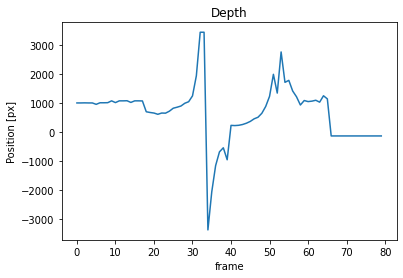

In [ ]:
import pandas as pd
#unit : mm
f = 1.67*10**(-3)
b = 104

#training data
cam_0=pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/cam_0/xydata.csv")
cam_1=pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/cam_1/xydata.csv")
cam_0y = cam_0.values[:,1]
cam_1y = cam_1.values[:,1]
cam_0x = cam_0.values[:,0]
cam_1x = cam_1.values[:,0]

X = []
Y = []
Z = []

for i in range(80):
  d = cam_0x[i]-cam_1x[i]
  if abs(d)>=3:
    X_tmp = int(cam_0x[i]+b/d)
    Y_tmp = int((cam_0y[i]+cam_1y[i])/2*(b/d))
    Z_tmp = int(abs(f*b/d*10000))
  else:
    X_tmp = X[i-1]
    Y_tmp = Y[i-1]
    Z_tmp = Z[i-1]
  X.append(X_tmp)
  Y.append(Y_tmp)
  Z.append(Z_tmp) 
print(Z)
plt.plot(Y)
plt.title('Depth')
plt.xlabel('frame')
plt.ylabel('Position [px]')

In [ ]:
# PYTHON_MATPLOTLIB_3D_PLOT_02

# 3次元散布図

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Figureを追加
fig = plt.figure(figsize = (8, 8))

# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# Axesのタイトルを設定
ax.set_title("3D Reconstruction", size = 20)

# 軸ラベルを設定
ax.set_xlabel("x", size = 14, color = "r")
ax.set_ylabel("y", size = 14, color = "r")
ax.set_zlabel("z", size = 14, color = "r")

ax.set_xlim(0,500)
ax.set_ylim(0,500)
ax.set_zlim(0,500)

ax.set_xlim

# 軸目盛を設定
#ax.set_xticks([-5.0, -2.5, 0.0, 2.5, 5.0])
#ax.set_yticks([-5.0, -2.5, 0.0, 2.5, 5.0])

# 曲線を描画
ax.scatter(cam_0y, Z, X, s = 200, c = "red")

plt.show()

In [ ]:
#画像の保存ディレクトリ
dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/3D_Reconstruction'
#out_img='/content/gdrive/My Drive/YAMAKAWA_LAB/motion_tracking/wavehand/output'
if not os.path.exists(dst_img_dir):
  os.mkdir(dst_img_dir)

for i in range(80):
  # Figureを追加
  fig = plt.figure(figsize = (8, 8))

  # 3DAxesを追加
  ax = fig.add_subplot(111, projection='3d')

  # Axesのタイトルを設定
  ax.set_title("3D Reconstruction", size = 20)

  # 軸ラベルを設定
  ax.set_xlabel("x", size = 14, color = "r")
  ax.set_ylabel("y", size = 14, color = "r")
  ax.set_zlabel("z", size = 14, color = "r")

  # 軸目盛を設定
  ax.set_xlim(0,500)
  ax.set_ylim(0,500)
  ax.set_zlim(0,500)
  #ax.set_xticks([-5.0, -2.5, 0.0, 2.5, 5.0])
  #ax.set_yticks([-5.0, -2.5, 0.0, 2.5, 5.0])

  # 曲線を描画
  #ax.scatter(Y[i], Z[i], X[i], s = 200, c = "red")
  ax.scatter(trajectory_y[i], Z[i], trajectory_x[i], s = 200, c = "red")
  dst_file = "{dir}/{index:02d}.jpg".format(dir=dst_img_dir,index=i+1)
  plt.savefig(dst_file)

#Making Video From Images

In [ ]:
#処理後の画像を動画に変換する
import glob

#dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/cam_1/Processed'
#dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/3/calibrate'
#dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/1/cam_1/ColorTracking-TemplateMatching'
#dst_img_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/opticalFlow'
#dst_img_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/color_tracking/'
dst_img_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/Body'
#dst_img_dir='/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/color_template_tracking'#ObjectTracking/20221221/1/cam_1/ColorTracking-TemplateMatching'
src_img_dir=dst_img_dir

#フォルダに存在するファイルを取得する、0001.jpg~0005.jpg→{}/*.jpg
src_files=glob.glob("{}/*.jpg".format(src_img_dir))
src_files.sort()

#処理後の画像から動画を作る
!ffmpeg -framerate 10 -i "$src_img_dir/%03d.jpg" '/content/gdrive/My Drive/YAMAKAWA_LAB/YOLO_labelimg/Images/13_files/Body.mp4' #"/content/gdrive/My Drive/YAMAKAWA_LAB/ObjectTracking/20221221/1/color-template.mp4"